# Regression discontinuity

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import patsy, warnings
import statsmodels.formula.api as smf, statsmodels.api as sm

from sklearn.linear_model import LinearRegression as lr ## Linear regression

warnings.filterwarnings('ignore')
dpi_f = 600

## Figurewith 2D bins

In [2]:
data = pd.read_stata("https://github.com/d2cml-ai/python_visual_library/raw/main/data/evaluation.dta")

cutoff = 58

data = data[data.treatment_locality == 1]
data['treatment'] = data.poverty_index <= cutoff
features = ["poverty_index", "health_expenditures", "treatment"]
data = data[features]
data.head()

poverty_index  health_expenditures  treatment
0      55.950542            15.185455       True
1      55.950542            19.580902       True
2      46.058731            13.076257       True
3      46.058731             2.398854       True
4      54.095825             0.000000       True

In [3]:
data.sort_values("poverty_index", inplace=True)

data_treat = data[data.treatment == True]
data_crtl = data[data.treatment == False]

fmla = "health_expenditures ~ bs(poverty_index, df = 3)"

y, x = patsy.dmatrices(fmla, data_treat, return_type="dataframe")
y1, x1 = patsy.dmatrices(fmla, data_crtl, return_type="dataframe")

data_treat['yhat'] = np.concatenate(lr().fit(x, y).predict(x))
data_crtl['yhat'] = np.concatenate(lr().fit(x1, y1).predict(x1))

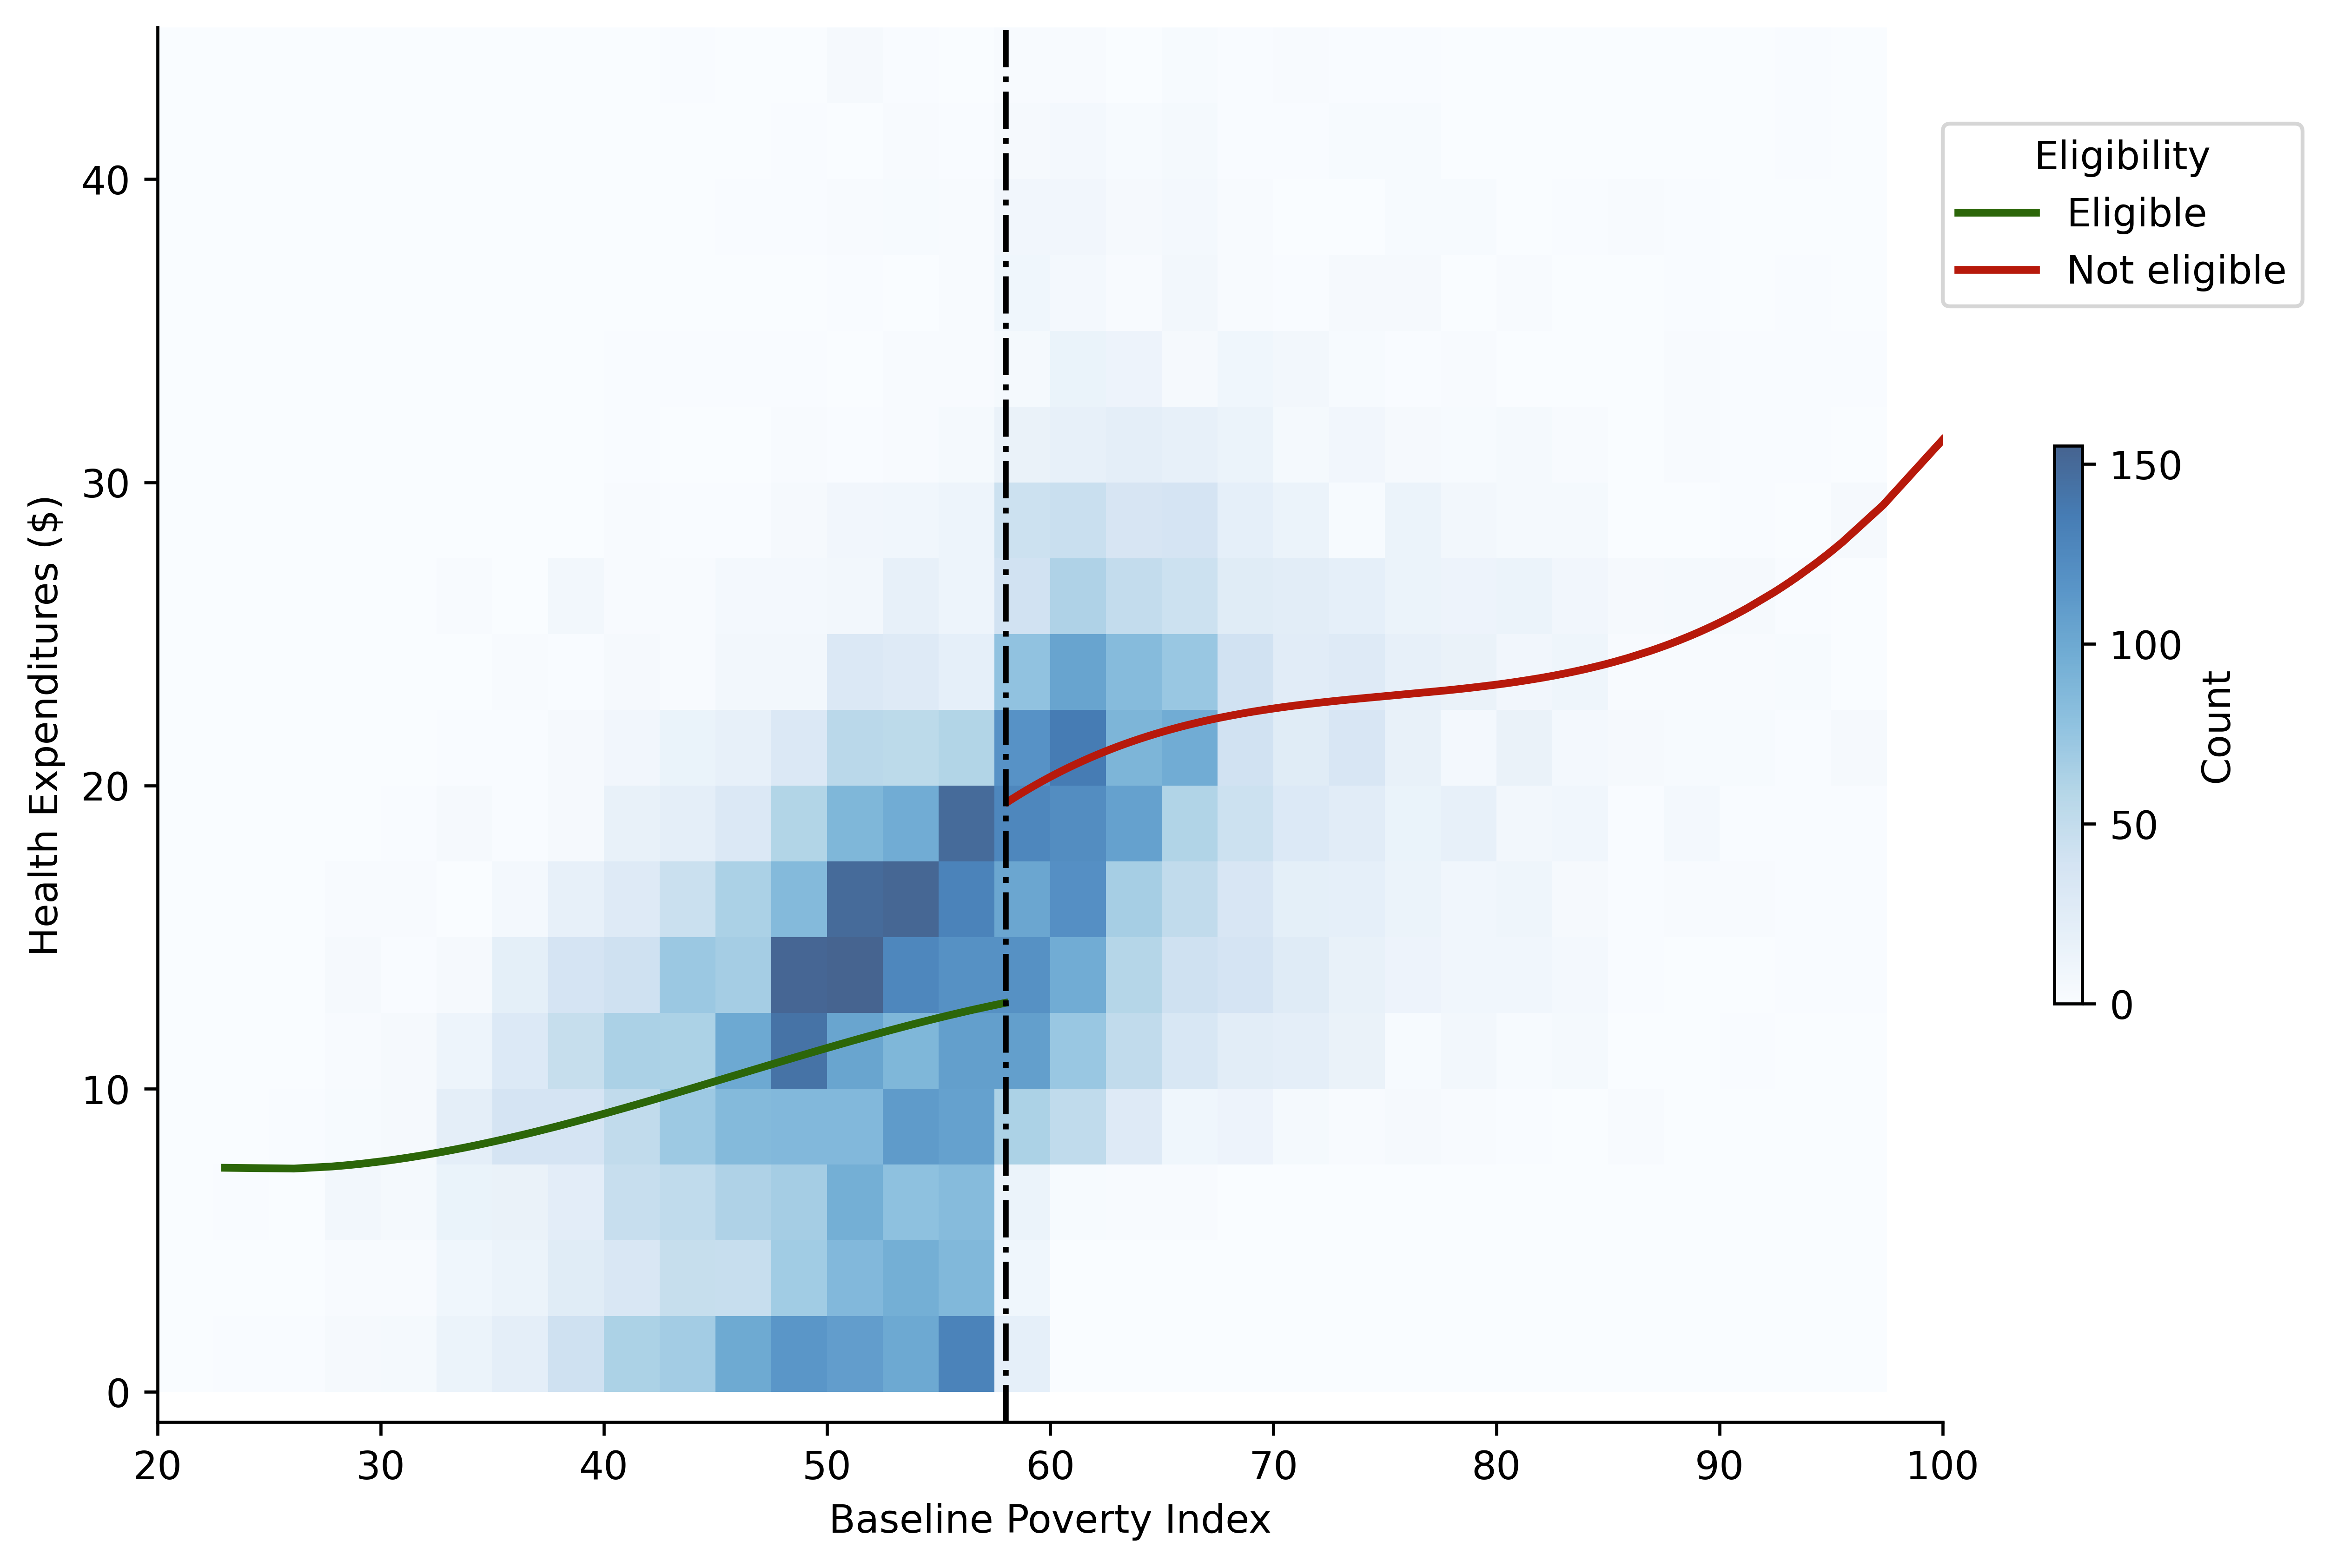

In [4]:
fig = plt.figure(figsize = (8, 5), dpi = dpi_f)
bins_xy = np.arange(0, 100, 2.5)

colors = ["#2c6609", "#b7190b"]

x, y = "porverty_index", "healt_expenditures"
ax = fig.add_axes([.1, 1, 1, 1])
plt.hist2d(
    "poverty_index", "health_expenditures", data = data
    , cmap = "Blues"
    , bins = (bins_xy, bins_xy)
    , alpha = .75
)
ax.plot("poverty_index", "yhat", data = data_treat, color = colors[0], label = "Eligible", lw = 2)
ax.plot("poverty_index", "yhat", data = data_crtl, color = colors[1], label = "Not eligible", lw = 2)
omit = ['right', 'top']

plt.colorbar(shrink = .4, label = "Count", ticks = np.arange(0, 151, 50))
ax.legend(title = "Eligibility", loc = (1, .8))
ax.set_ylim(-1, 45)
ax.axvline(cutoff, color = "black", linestyle = "-.", )
ax.set_xlim(20, 100)
ax.spines[omit].set_visible(False)
ax.set_ylabel("Health Expenditures ($)")
ax.set_xlabel("Baseline Poverty Index");
plt.show();

## Results with differet bandwidths

In [5]:
from rdrobust import rdrobust, rdplot
data = pd.read_stata("https://github.com/d2cml-ai/python_visual_library/raw/main/data/RDD_data.dta")
data['tmt_status'] = np.where(data.tmt_status == "Control", 0, 1)
data.head()
bw = np.arange(.5, 6.1, .5)
cutoff = np.mean(data.cutoff)

In [6]:
coef = []
s_e = []

for i in bw:
    rdd_est = rdrobust(y=data.tmt_status, x=data.pmt_score, c = cutoff, b=.5, h = i,  kernel = "tri")
    coef_0 = rdd_est.coef.iloc[0, 0]
    stde = rdd_est.se.iloc[0, 0]
    coef.append(coef_0)
    s_e.append(stde)

u = coef + 1.96 * np.array(s_e)
l = coef - 1.96 * np.array(s_e)

df = pd.DataFrame(
    {'coef': coef, 'l': l, "u": u, "bw": bw}
)
df1 = pd.melt(df, id_vars = ['coef', 'bw'], value_vars=['l', 'u'])
df.head()

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


coef         l         u   bw
0  0.738404  0.359887  1.116922  0.5
1  0.544532  0.214505  0.874560  1.0
2  0.645092  0.354021  0.936162  1.5
3  0.597275  0.344312  0.850238  2.0
4  0.548945  0.318897  0.778993  2.5

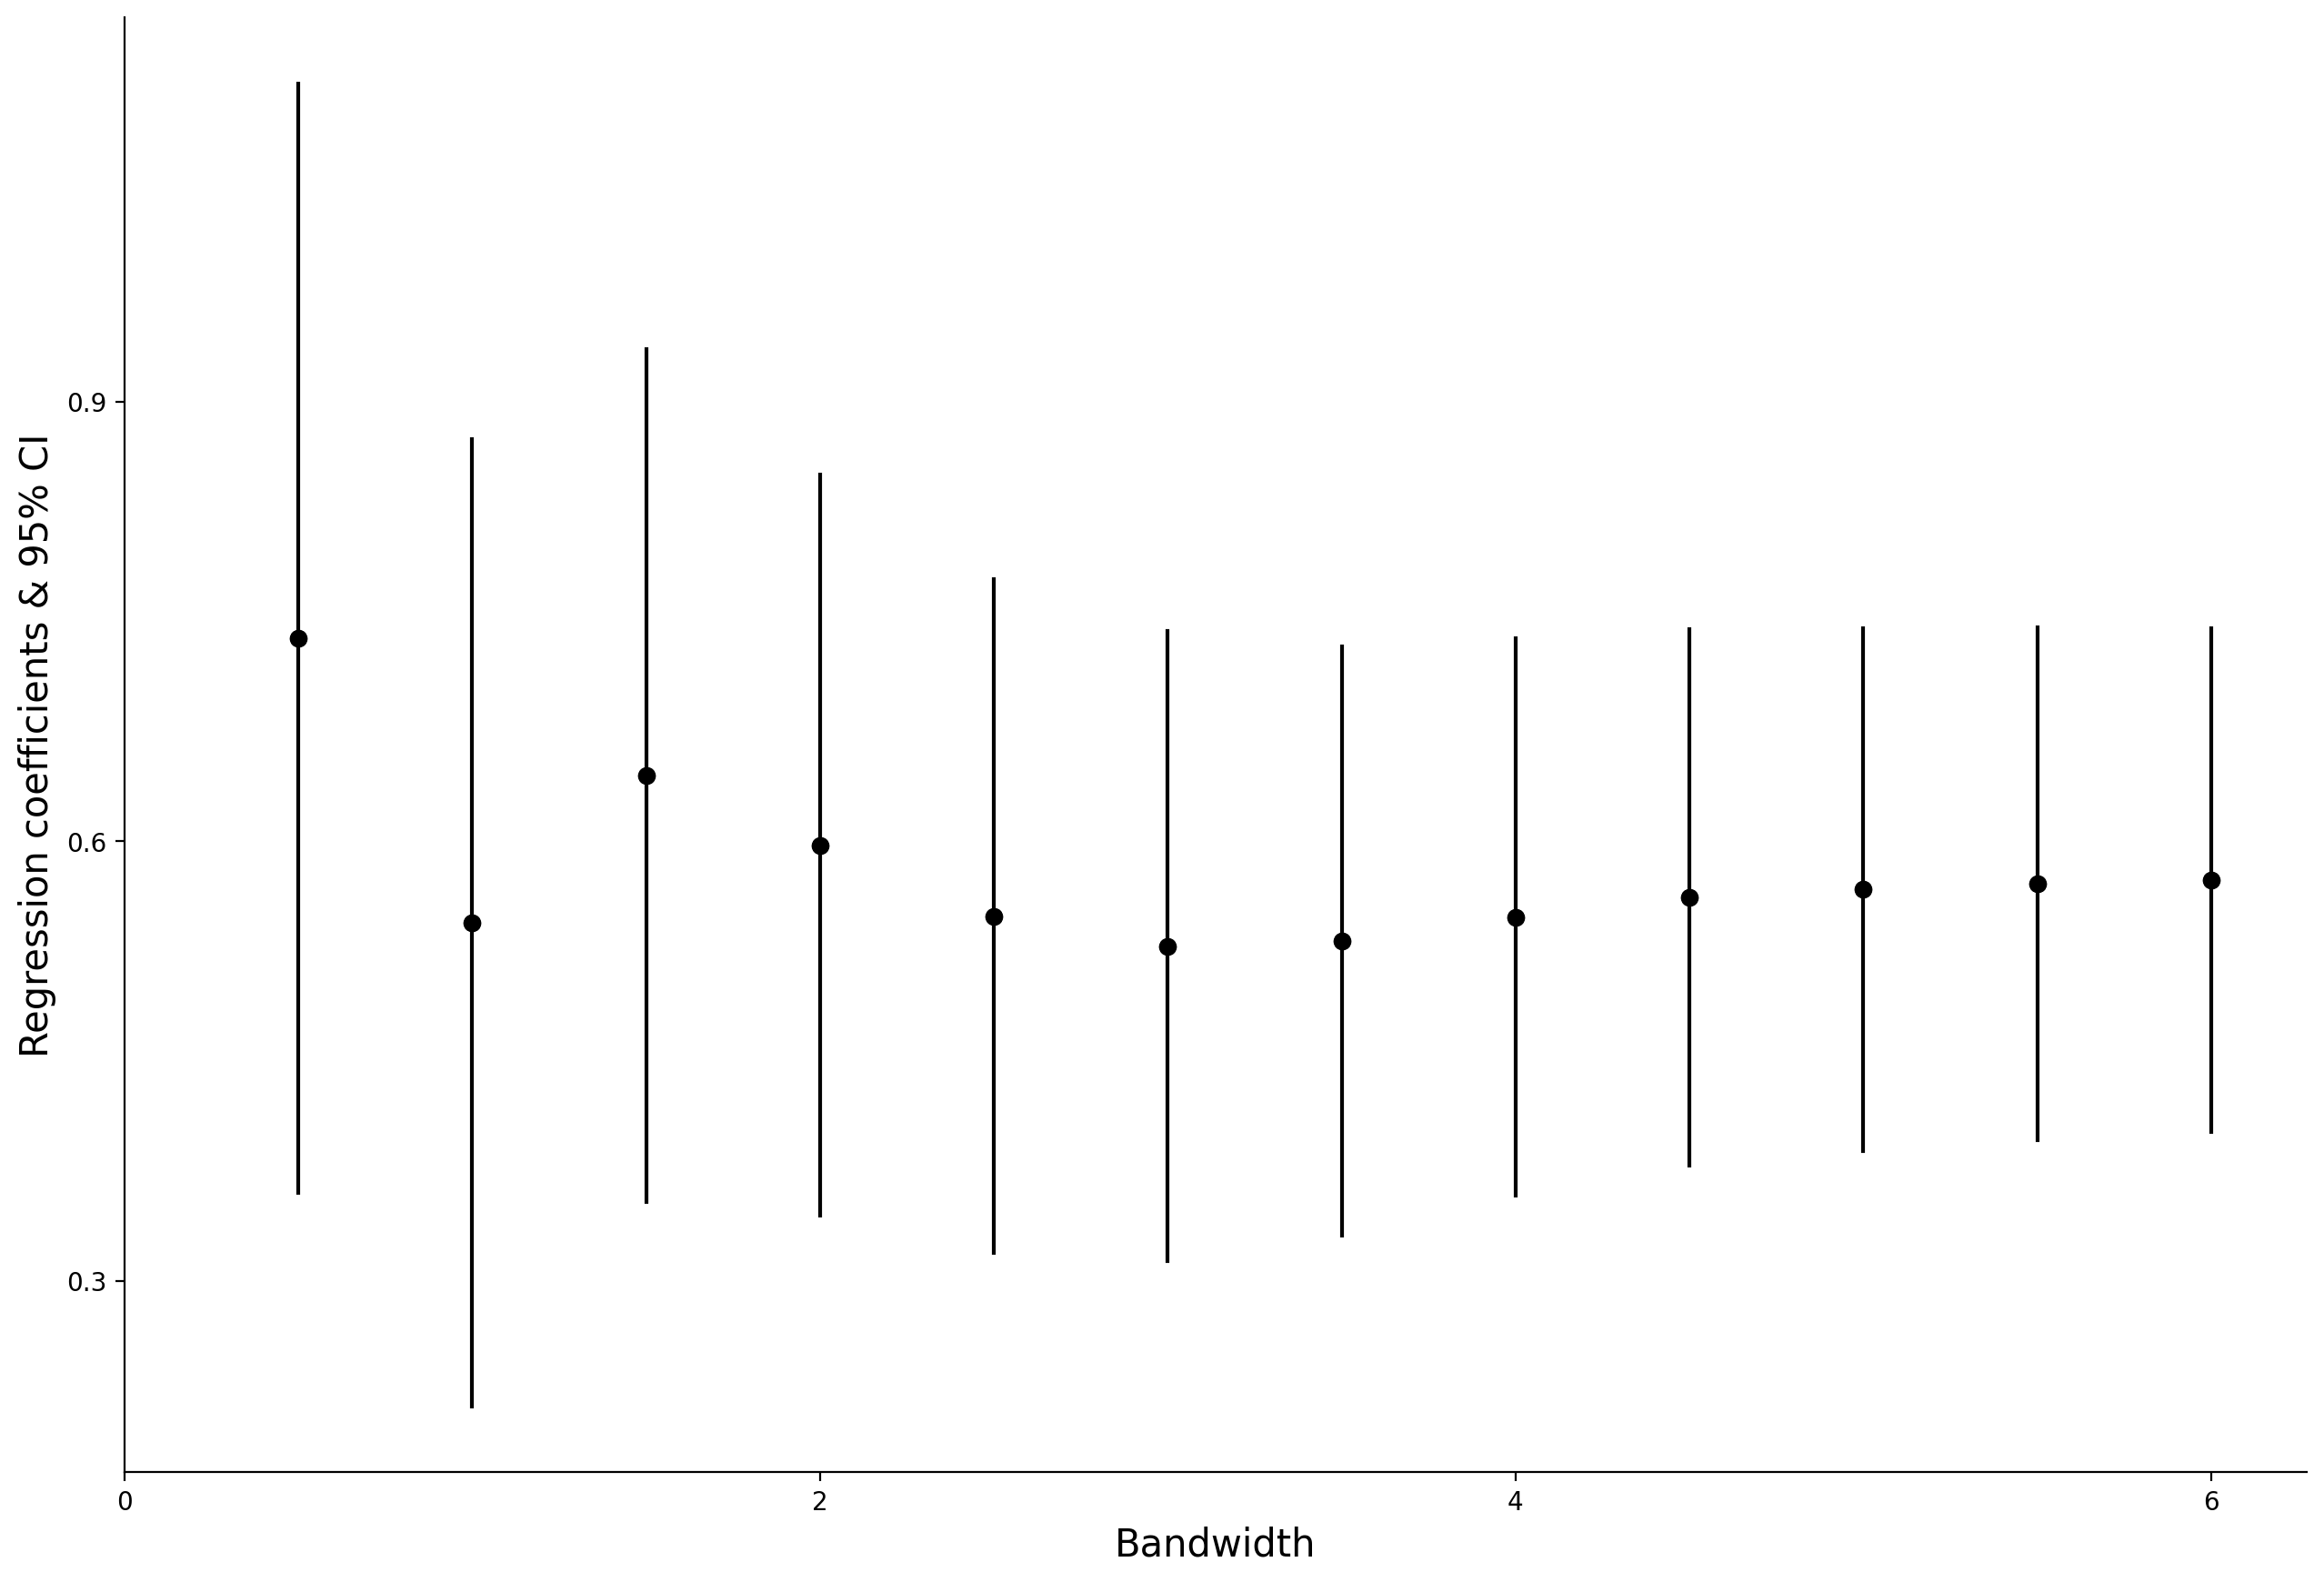

In [7]:
fig = plt.figure(dpi = 200, figsize=(12, 8), facecolor='white')
ax = fig.add_axes([.1, 1, 1, 1])

plt.scatter('bw', 'coef', data = df1, c = "black")
for i in bw:
    r_d = df1[df1.bw == i]
    plt.plot('bw', 'value', data = r_d, color = "black")
    
omit = ['top', 'right']
ax.spines[omit].set_visible(False)
ax.set_xticks(np.arange(0, 6.1, 2))
ax.set_yticks(np.arange(0.3, 1, .3))
ax.set_ylabel("Regression coefficients & 95% CI", size = 15)
ax.set_xlabel("Bandwidth", size = 15);
plt.show();


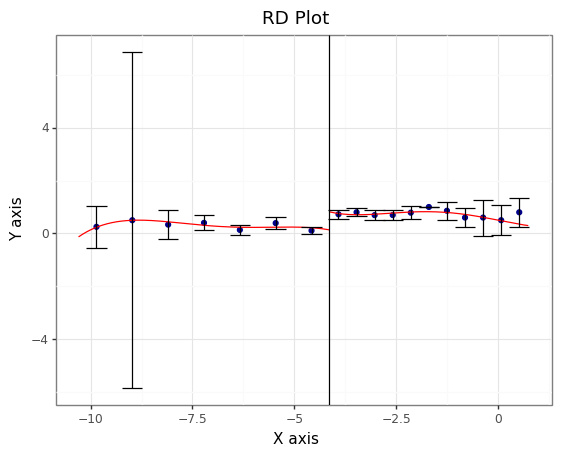

In [8]:
rdplot(y=data.tmt_status, x=data.pmt_score, c = cutoff, kernel = "tri", ci=95);

## Figure with Confidence Intervals

In [9]:
data2 = pd.read_stata("https://github.com/worldbank/r-econ-visual-library/raw/master/Library/Data/RDD_data.dta")
cutoff = np.unique(data2.cutoff)[0]
# cutoff
data2['treatment'] = data2['pmt_score'] >= cutoff
data2['tmt_status'] = np.where(data2.tmt_status == "Control", 0, 1)
data2.sort_values('pmt_score', inplace = True)

In [10]:
data2_tr = data2[data2['treatment'] == True]
data2_cr = data2[data2['treatment'] == False]

fmla = "tmt_status ~ bs(pmt_score, 3)"

ytr, xtr = patsy.dmatrices(fmla, data = data2_tr, return_type = 'dataframe')
ycr, xcr = patsy.dmatrices(fmla, data = data2_cr, return_type = 'dataframe')

ols_tr = sm.OLS(ytr, xtr).fit()
data2_tr['yhat'] = ols_tr.predict(xtr)
data2_tr['upper'] = ols_tr.get_prediction().summary_frame()['mean_ci_upper']
data2_tr['lower'] = ols_tr.get_prediction().summary_frame()['mean_ci_lower']

ols_cr = sm.OLS(ycr, xcr).fit()
data2_cr['yhat'] = ols_cr.predict(xcr)
data2_cr['upper'] = ols_cr.get_prediction().summary_frame()['mean_ci_upper']
data2_cr['lower'] = ols_cr.get_prediction().summary_frame()['mean_ci_lower']

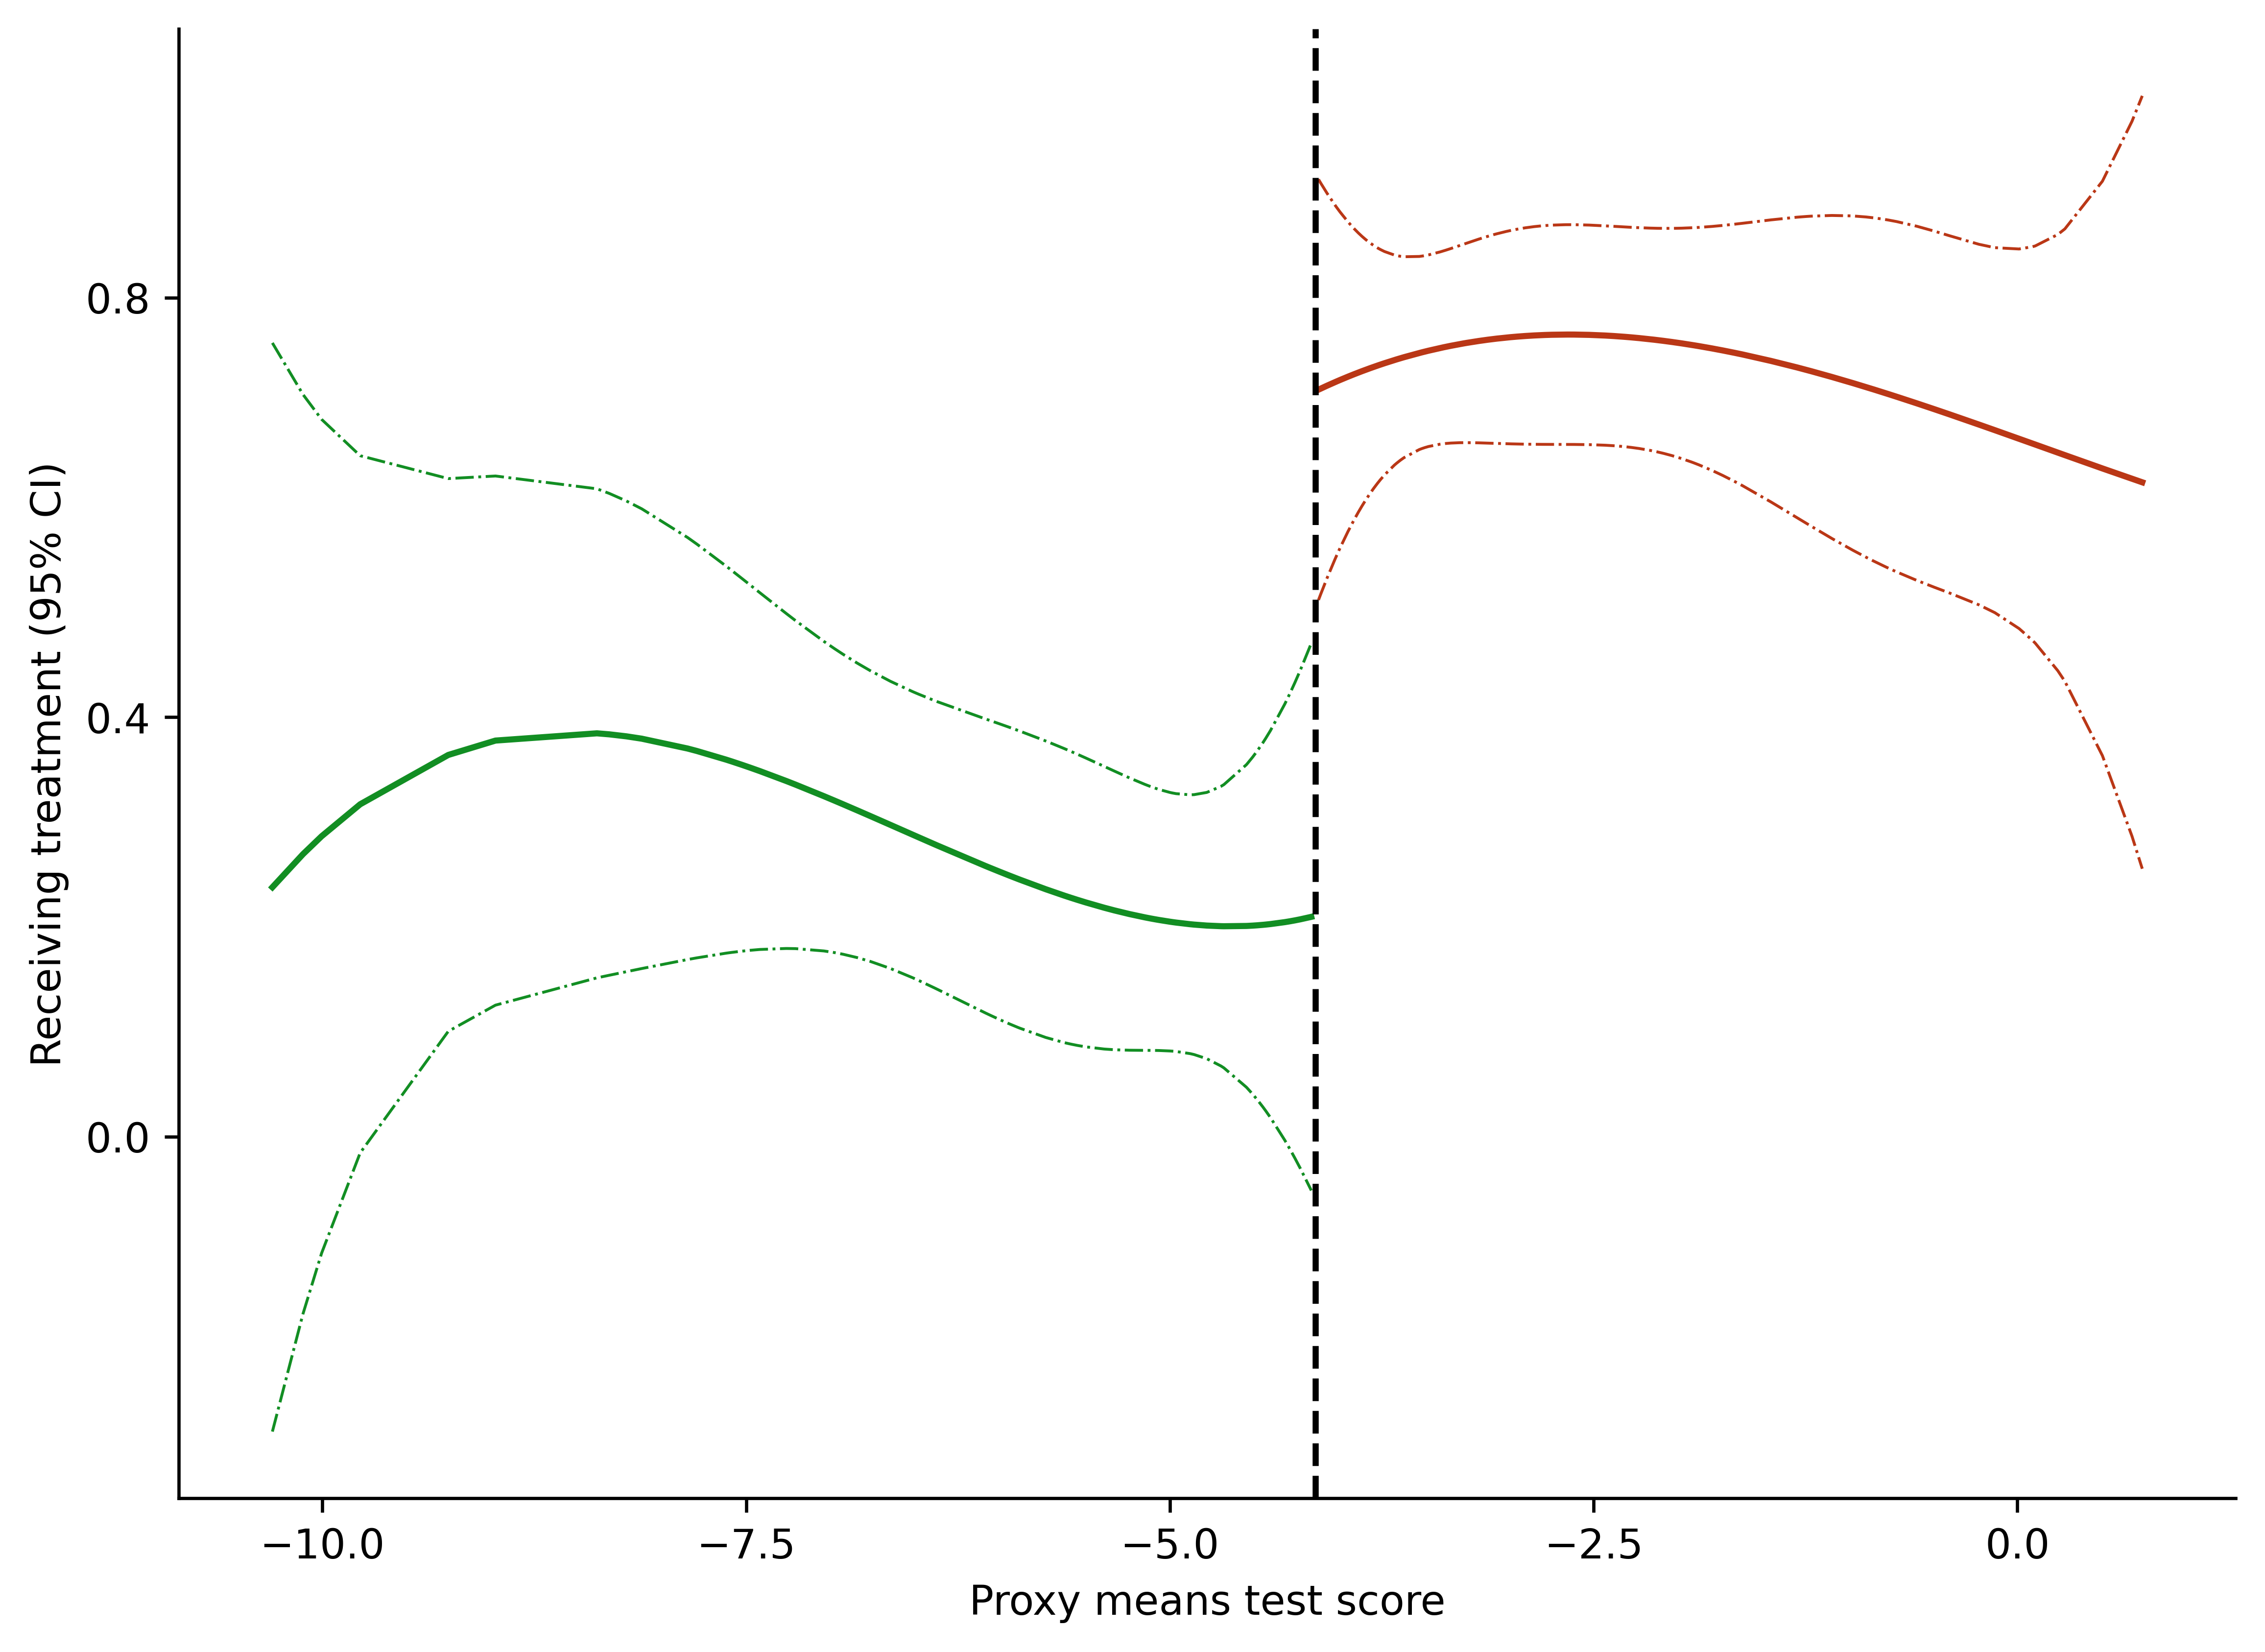

In [11]:
fig = plt.figure(figsize = (7, 5), facecolor = 'white', dpi = dpi_f)
ax = fig.add_axes([.1, 1, 1, 1])

colors = ["#ba3716", "#128e23"]

ax.plot('pmt_score', 'yhat', data = data2_tr, color = colors[0])
ax.plot('pmt_score', 'yhat', data = data2_cr, color = colors[1])
ax.plot('pmt_score', 'lower', data = data2_tr, linestyle = '-.', color = colors[0], lw = .7)
ax.plot('pmt_score', 'upper', data = data2_tr, linestyle = '-.', color = colors[0], lw = .7)
ax.plot('pmt_score', 'lower', data = data2_cr, linestyle = '-.', color = colors[1], lw = .7)
ax.plot('pmt_score', 'upper', data = data2_cr, linestyle = '-.', color = colors[1], lw = .7)

ax.axvline(cutoff, color = "black", lw = 1.5, linestyle = "--")
omit = ['right', 'top']
ax.spines[omit].set_visible(False)
ax.set_xlabel("Proxy means test score")
ax.set_ylabel("Receiving treatment (95% CI)")
ax.set_xticks(np.arange(-10, 1, 2.5))
ax.set_yticks(np.arange(0, .81, .4));
plt.show();

## Figure with Confidence Intervals and Points

In [12]:
## Using data2 
data2 = pd.read_stata("https://github.com/worldbank/r-econ-visual-library/raw/master/Library/Data/RDD_data.dta")
cutoff = np.unique(data2.cutoff)[0]
# cutoff
data2['treatment'] = data2['pmt_score'] >= cutoff
data2['tmt_status'] = np.where(data2.tmt_status == "Control", 0, 1)
data2.sort_values('pmt_score', inplace = True)

data2_tr = data2[data2['treatment'] == True]
data2_cr = data2[data2['treatment'] == False]

fmla = "tmt_status ~ bs(pmt_score, 3)"

ytr, xtr = patsy.dmatrices(fmla, data = data2_tr, return_type = 'dataframe')
ycr, xcr = patsy.dmatrices(fmla, data = data2_cr, return_type = 'dataframe')

ols_tr = sm.OLS(ytr, xtr).fit()
data2_tr['yhat'] = ols_tr.predict(xtr)
data2_tr['upper'] = ols_tr.get_prediction().summary_frame()['mean_ci_upper']
data2_tr['lower'] = ols_tr.get_prediction().summary_frame()['mean_ci_lower']

ols_cr = sm.OLS(ycr, xcr).fit()
data2_cr['yhat'] = ols_cr.predict(xcr)
data2_cr['upper'] = ols_cr.get_prediction().summary_frame()['mean_ci_upper']
data2_cr['lower'] = ols_cr.get_prediction().summary_frame()['mean_ci_lower']

In [13]:
bw = 1.015
br = np.arange(min(data2.pmt_score), max(data2.pmt_score) + .1, bw)

n = data2.groupby(pd.cut(data2.pmt_score, br)).count()
mm = data2.groupby(pd.cut(data2.pmt_score, br)).mean()

df4 = pd.DataFrame()
df4['n']= n['uuid'] * 4
df4[['pmt', 'tmt', 'f']]  = mm[['pmt_score', 'tmt_status', 'treatment']]
df4_cr = df4[df4.f == 0]
df4_tr = df4[df4.f !=0]

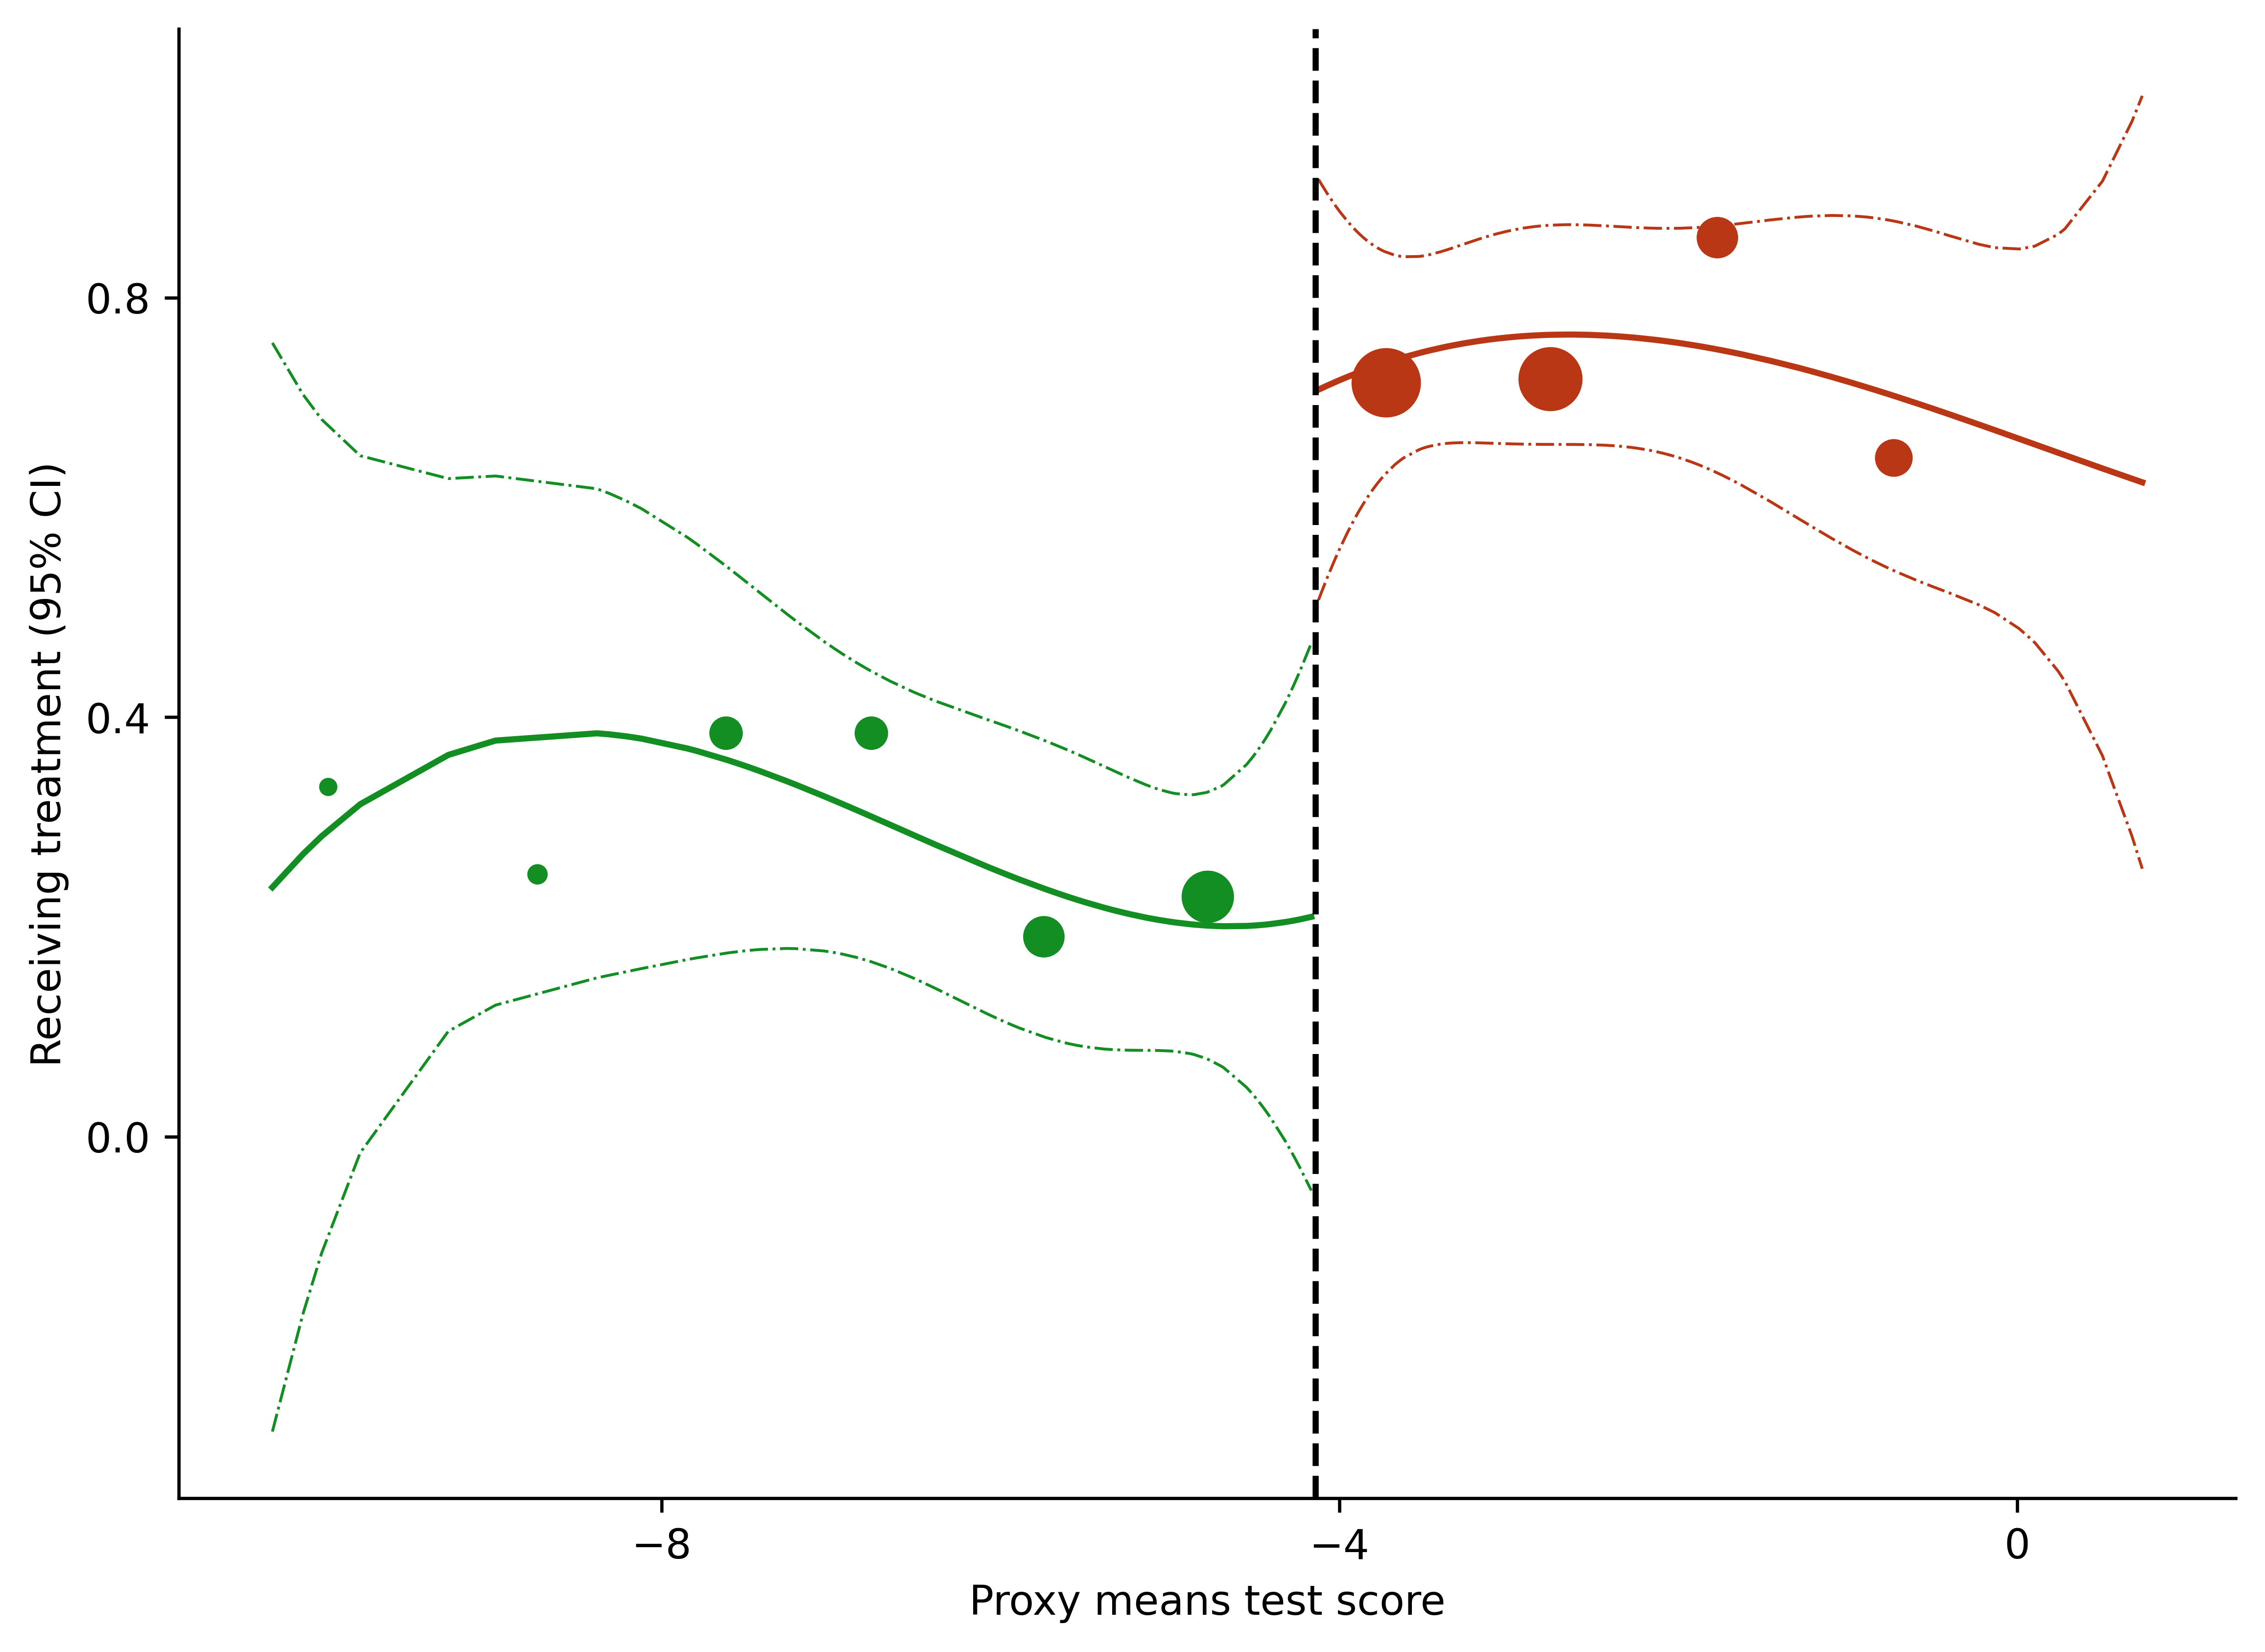

In [14]:
fig = plt.figure(figsize = (7, 5), facecolor = 'white', dpi = dpi_f)
ax = fig.add_axes([.1, 1, 1, 1])

colors = ["#ba3716", "#128e23"]

ax.plot('pmt_score', 'yhat', data = data2_tr, color = colors[0])
ax.plot('pmt_score', 'yhat', data = data2_cr, color = colors[1])
ax.plot('pmt_score', 'lower', data = data2_tr, linestyle = '-.', color = colors[0], lw = .7)
ax.plot('pmt_score', 'upper', data = data2_tr, linestyle = '-.', color = colors[0], lw = .7)
ax.plot('pmt_score', 'lower', data = data2_cr, linestyle = '-.', color = colors[1], lw = .7)
ax.plot('pmt_score', 'upper', data = data2_cr, linestyle = '-.', color = colors[1], lw = .7)
ax.scatter("pmt", "tmt", s = "n", data = df4_tr, color = colors[0])
ax.scatter("pmt", "tmt", s = "n", data = df4_cr, color = colors[1])

ax.axvline(cutoff, color = "black", lw = 1.5, linestyle = "--")
omit = ['right', 'top']
ax.spines[omit].set_visible(False)
ax.set_xlabel("Proxy means test score")
ax.set_ylabel("Receiving treatment (95% CI)")
ax.set_xticks(np.arange(-8, 1, 4))
ax.set_yticks(np.arange(0, .81, .4));
plt.show();

## Figure with Point estimate

In [15]:
data = pd.read_stata("https://github.com/d2cml-ai/python_visual_library/raw/main/data/evaluation.dta")

cutoff = 58

data = data[data.treatment_locality == 1]
data['treatment'] = data.poverty_index <= cutoff
features = ["poverty_index", "health_expenditures", "treatment"]
data = data[features]


data.sort_values("poverty_index", inplace=True)

data_treat = data[data.treatment == True]
data_crtl = data[data.treatment == False]

fmla = "health_expenditures ~ bs(poverty_index, df = 3)"

y, x = patsy.dmatrices(fmla, data_treat, return_type="dataframe")
y1, x1 = patsy.dmatrices(fmla, data_crtl, return_type="dataframe")

data_treat['yhat'] = np.concatenate(lr().fit(x, y).predict(x))
data_crtl['yhat'] = np.concatenate(lr().fit(x1, y1).predict(x1))

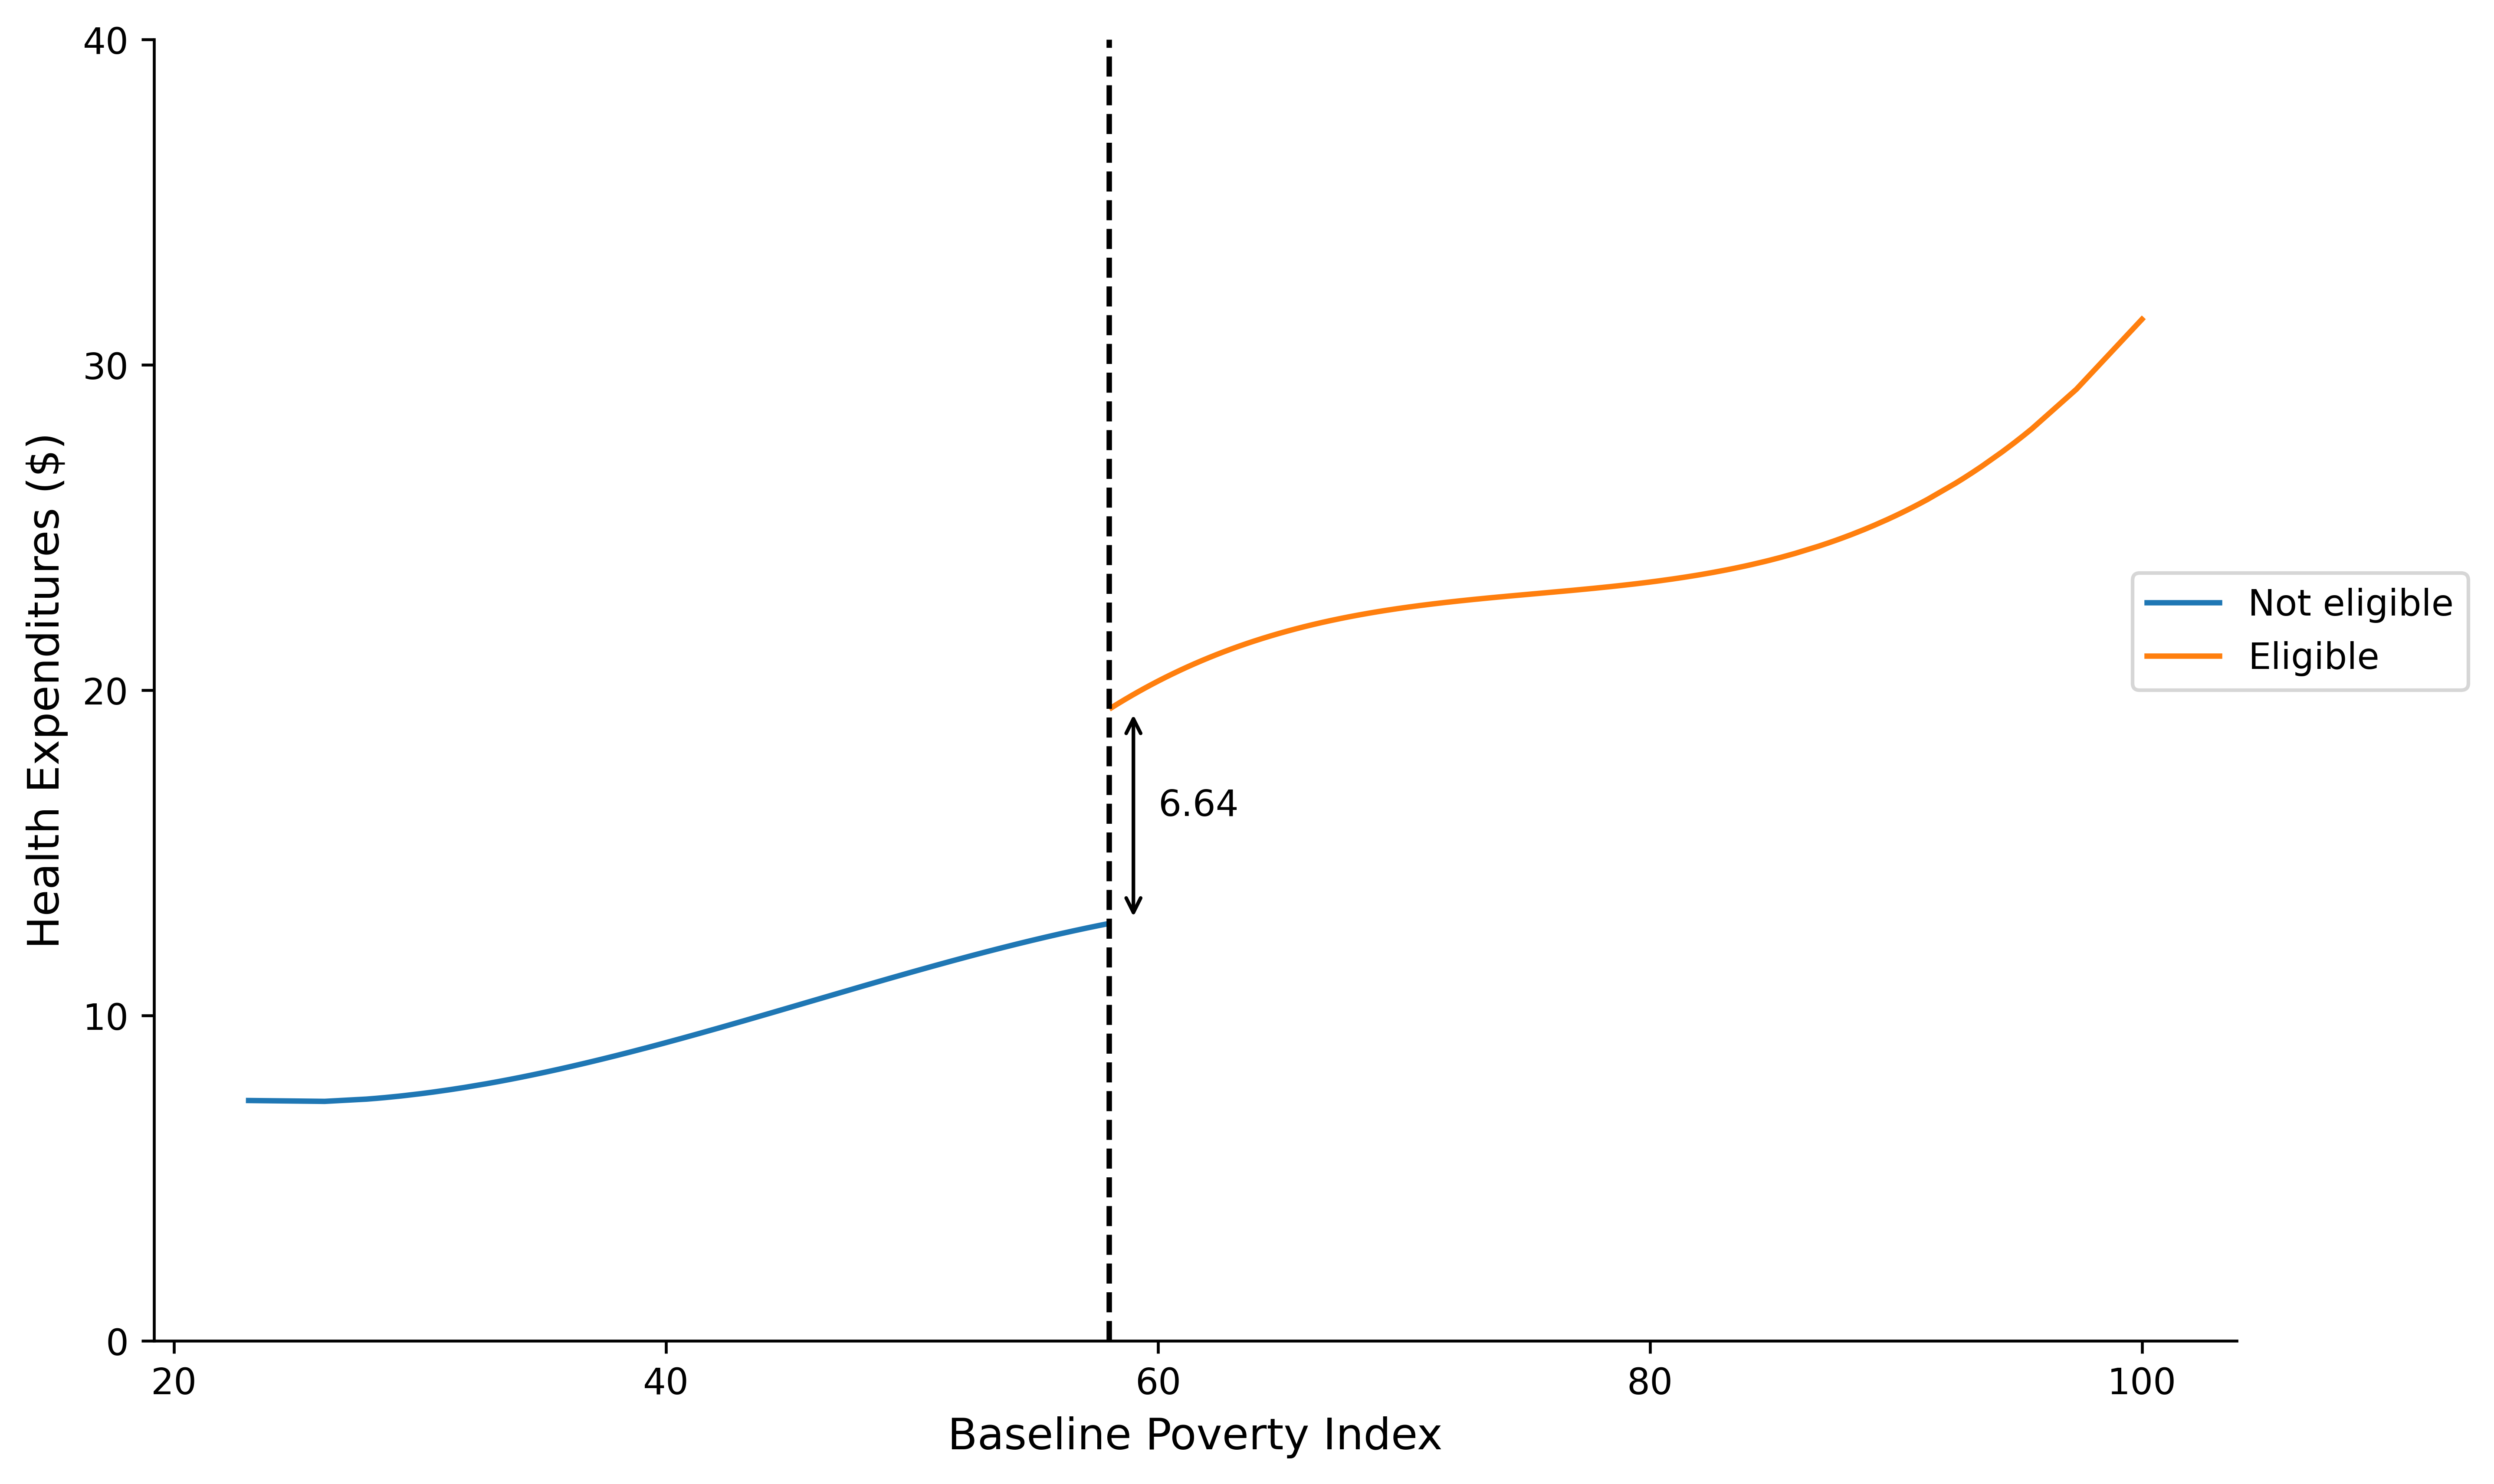

In [16]:
min_crtl = min(data_crtl.yhat)
max_treat = max(data_treat.yhat)
effect = np.round((min_crtl - max_treat), 2)
c = np.mean([min_crtl, max_treat])

fig = plt.figure(facecolor = 'white', figsize=(8, 5), dpi = dpi_f)
ax = fig.add_axes([.1, 1,1, 1])

ax.plot("poverty_index", "yhat", data = data_treat, label = "Not eligible")
ax.plot("poverty_index", "yhat", data = data_crtl, label = "Eligible")

omit = ['right', 'top']
ax.spines[omit].set_visible(False)
ax.set_ylim(0, 40)
ax.legend(loc = (.95, .5))
ax.axvline(cutoff, color = "black", linestyle = "--")
ax.set_xlabel("Baseline Poverty Index", size = 12)
ax.set_ylabel("Health Expenditures ($)", size = 12)
ax.set_yticks(np.arange(0, 41, 10))
ax.set_xticks(np.arange(20, 101, 20))
ax.annotate(f"{effect}", xy = (60, c))
ax.annotate("", xy = (59, max_treat), xytext = (59, min_crtl), 
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"));
plt.show();

## Figure with Confidence Intervals and Histograms

In [17]:
## Using data2 
data2 = pd.read_stata("https://github.com/worldbank/r-econ-visual-library/raw/master/Library/Data/RDD_data.dta")
cutoff = np.unique(data2.cutoff)[0]
# cutoff
data2['treatment'] = data2['pmt_score'] >= cutoff
data2['tmt_status'] = np.where(data2.tmt_status == "Control", 0, 1)
data2.sort_values('pmt_score', inplace = True)

data2_tr = data2[data2['treatment'] == True]
data2_cr = data2[data2['treatment'] == False]

fmla = "tmt_status ~ bs(pmt_score, 3)"

ytr, xtr = patsy.dmatrices(fmla, data = data2_tr, return_type = 'dataframe')
ycr, xcr = patsy.dmatrices(fmla, data = data2_cr, return_type = 'dataframe')

ols_tr = sm.OLS(ytr, xtr).fit()
data2_tr['yhat'] = ols_tr.predict(xtr)
data2_tr['upper'] = ols_tr.get_prediction().summary_frame()['mean_ci_upper']
data2_tr['lower'] = ols_tr.get_prediction().summary_frame()['mean_ci_lower']

ols_cr = sm.OLS(ycr, xcr).fit()
data2_cr['yhat'] = ols_cr.predict(xcr)
data2_cr['upper'] = ols_cr.get_prediction().summary_frame()['mean_ci_upper']
data2_cr['lower'] = ols_cr.get_prediction().summary_frame()['mean_ci_lower']

In [18]:
bw = .2
br = np.arange(min(data2.pmt_score), max(data2.pmt_score) + .1, bw)

n = data2.groupby(pd.cut(data2.pmt_score, br)).count()
mm = data2.groupby(pd.cut(data2.pmt_score, br)).mean()

df4 = pd.DataFrame()
df4['n']= n['uuid']
df4[['pmt', 'tmt', 'f']]  = mm[['pmt_score', 'tmt_status', 'treatment']]
df4['n'] = ((df4.n - min(df4.n)) / (max(df4.n) - min(df4.n))) / 5

df4.head()

n        pmt  tmt    f
pmt_score                                    
(-10.295, -10.095]  0.01 -10.114500  0.0  0.0
(-10.095, -9.895]   0.01 -10.004590  1.0  0.0
(-9.895, -9.695]    0.01  -9.777099  0.0  0.0
(-9.695, -9.495]    0.00        NaN  NaN  NaN
(-9.495, -9.295]    0.00        NaN  NaN  NaN

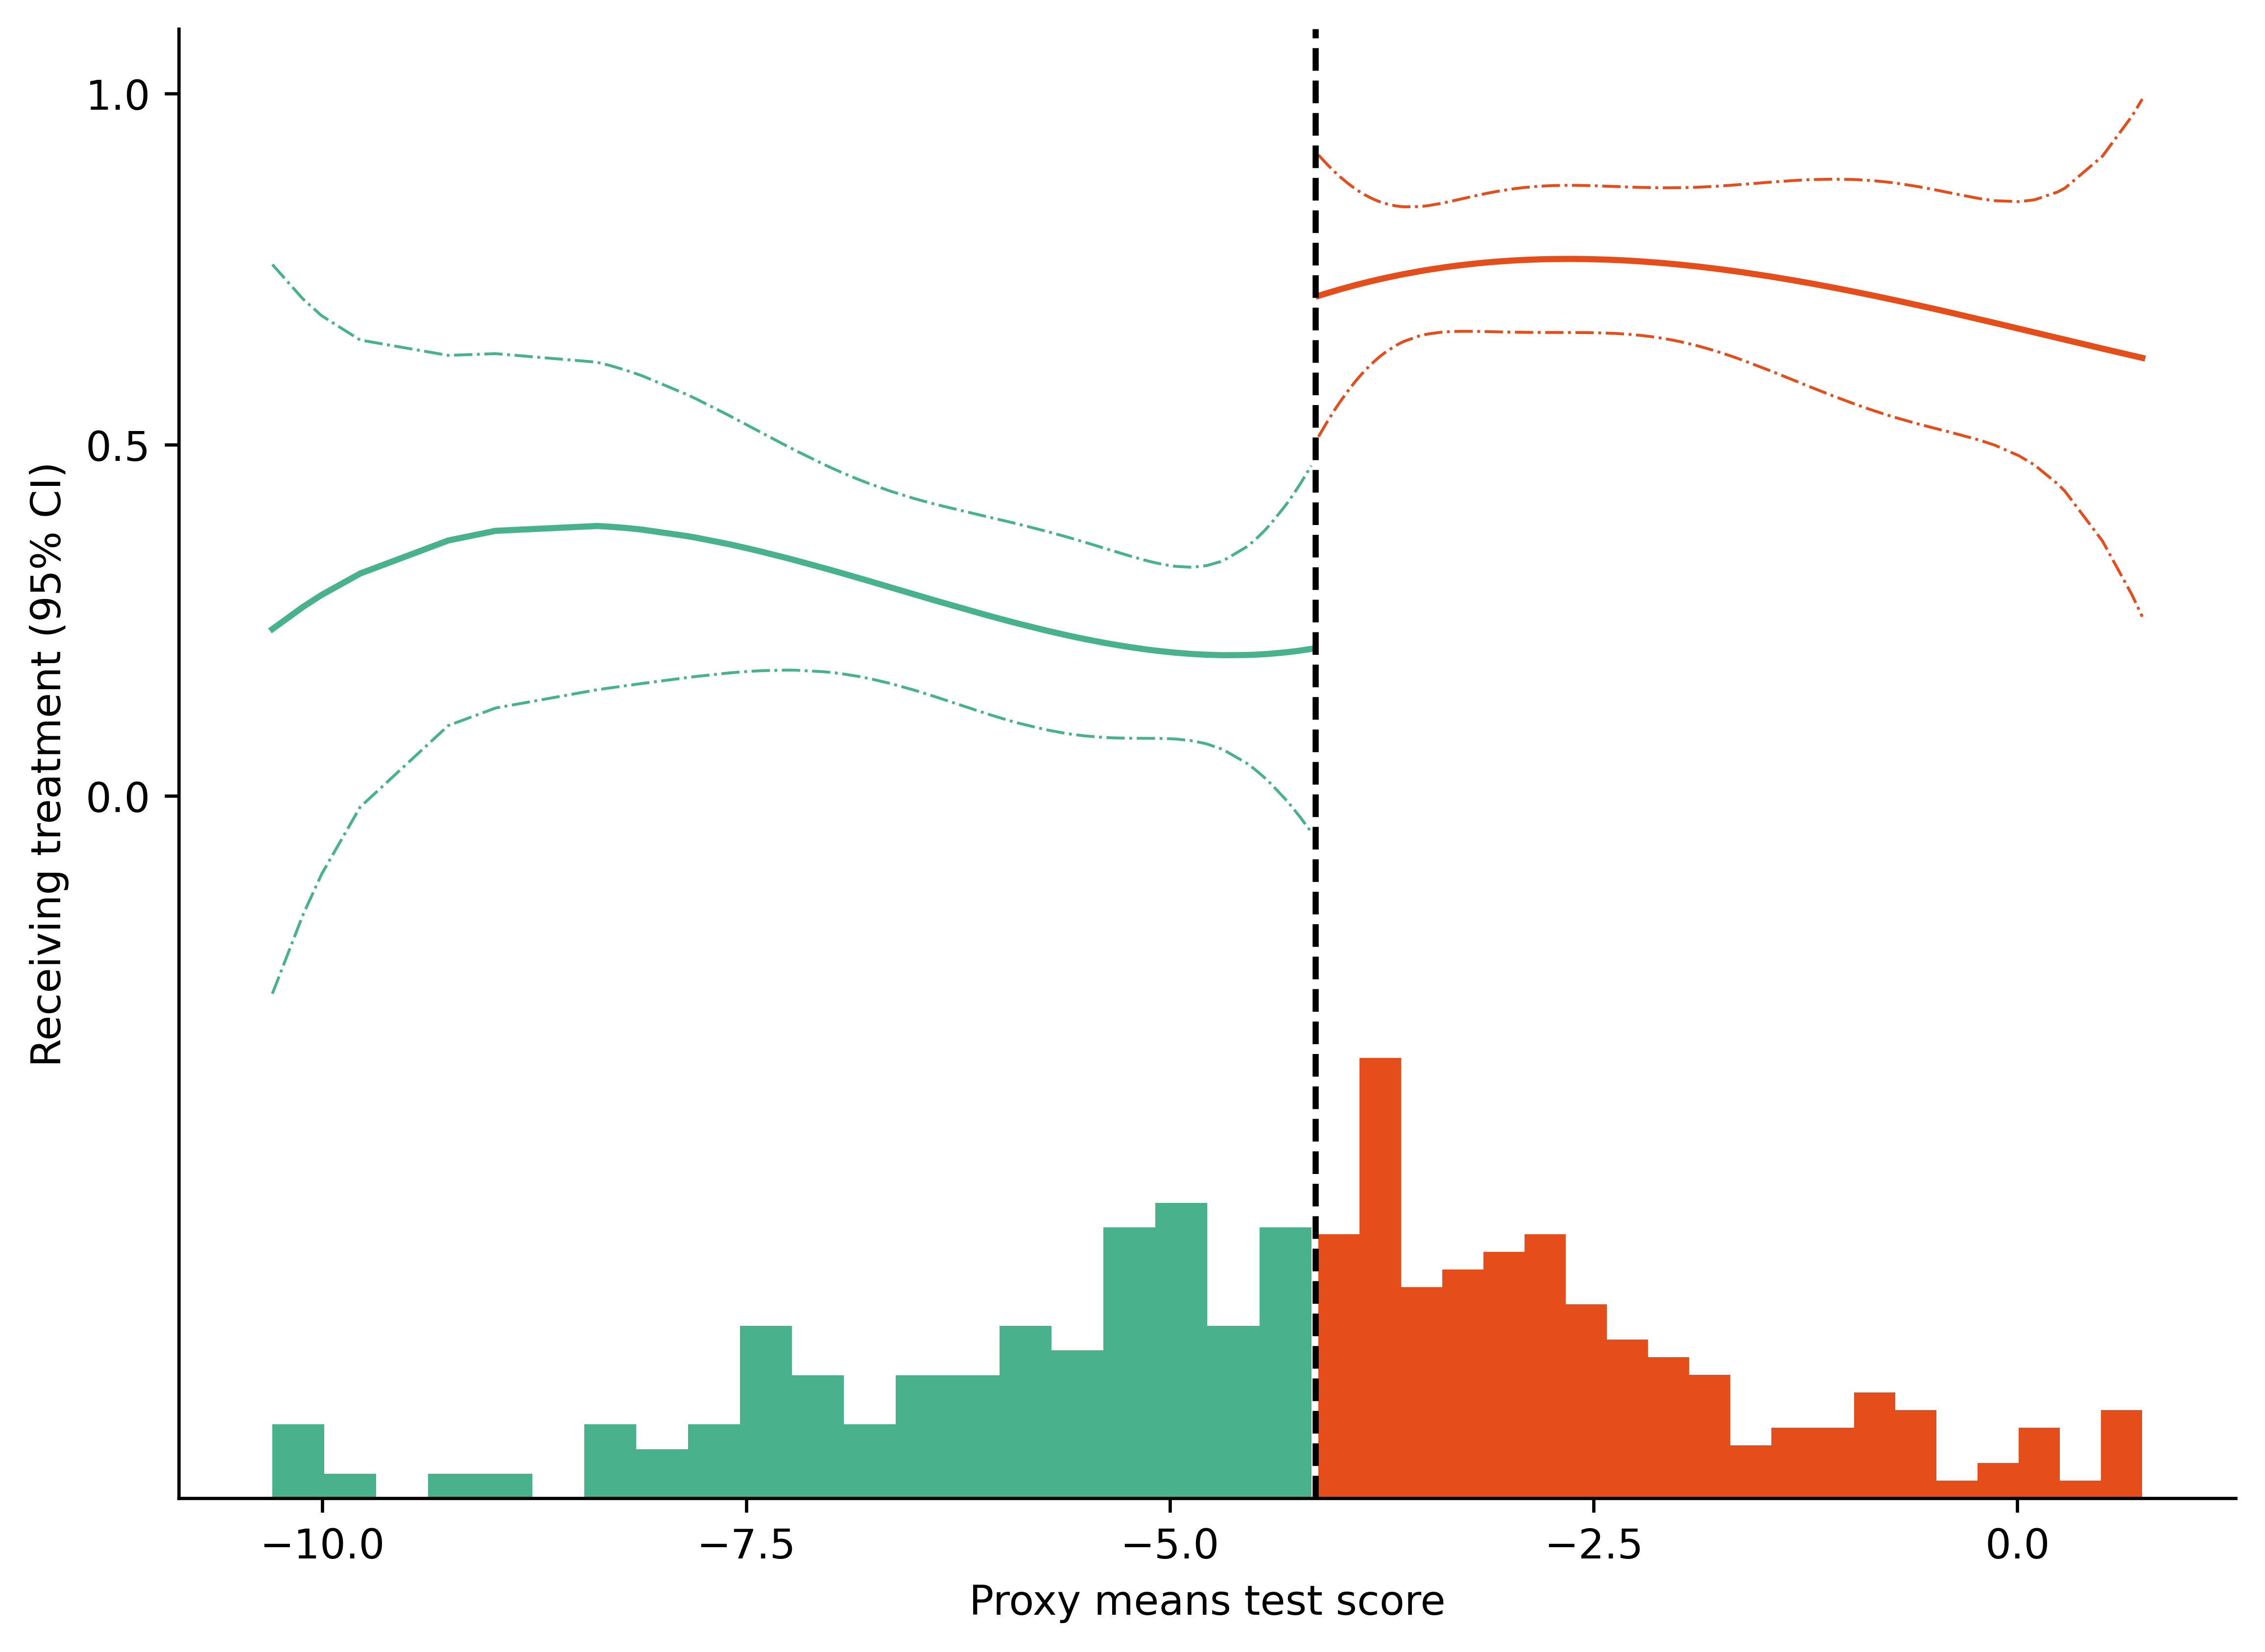

In [19]:
fig = plt.figure(figsize = (7, 5), facecolor = 'white', dpi = dpi_f)
ax = fig.add_axes([.1, 1, 1, 1])

colors = ["#e54e1b", "#47b28b"]

ax.plot('pmt_score', 'yhat', data = data2_tr, color = colors[0])
ax.plot('pmt_score', 'yhat', data = data2_cr, color = colors[1])
ax.plot('pmt_score', 'lower', data = data2_tr, linestyle = '-.', color = colors[0], lw = .7)
ax.plot('pmt_score', 'upper', data = data2_tr, linestyle = '-.', color = colors[0], lw = .7)
ax.plot('pmt_score', 'lower', data = data2_cr, linestyle = '-.', color = colors[1], lw = .7)
ax.plot('pmt_score', 'upper', data = data2_cr, linestyle = '-.', color = colors[1], lw = .7)
ax.hist("pmt_score", data = data2_tr, bins = 20, density=True, bottom = -1, log = False, color = colors[0])
ax.hist("pmt_score", data = data2_cr, bins = 20, density=True, bottom = -1, log = False, color = colors[1])
ax.axvline(cutoff, color = "black", lw = 1.5, linestyle = "--")
omit = ['right', 'top']
ax.spines[omit].set_visible(False)
ax.set_xlabel("Proxy means test score")
ax.set_ylabel("Receiving treatment (95% CI)")
ax.set_xticks(np.arange(-10, 1, 2.5))
ax.set_yticks(np.arange(0, 1.1, .5));
plt.show();

## Figure with Linear Fits and Local Linear Fits

In [20]:
## Using data2 
data2 = pd.read_stata("https://github.com/worldbank/r-econ-visual-library/raw/master/Library/Data/RDD_data.dta")
cutoff = np.unique(data2.cutoff)[0]
# cutoff
data2['treatment'] = data2['pmt_score'] >= cutoff
data2['tmt_status'] = np.where(data2.tmt_status == "Control", 0, 1)
data2.sort_values('pmt_score', inplace = True)

data2_tr = data2[data2['treatment'] == True]
data2_cr = data2[data2['treatment'] == False]

fmla = "tmt_status ~ pmt_score"

ytr, xtr = patsy.dmatrices(fmla, data = data2_tr, return_type = 'dataframe')
ycr, xcr = patsy.dmatrices(fmla, data = data2_cr, return_type = 'dataframe')

ols_tr = sm.OLS(ytr, xtr).fit()
data2_tr['yhat'] = ols_tr.predict(xtr)
data2_tr['upper'] = ols_tr.get_prediction().summary_frame()['mean_ci_upper']
data2_tr['lower'] = ols_tr.get_prediction().summary_frame()['mean_ci_lower']

ols_cr = sm.OLS(ycr, xcr).fit()
data2_cr['yhat'] = ols_cr.predict(xcr)
data2_cr['upper'] = ols_cr.get_prediction().summary_frame()['mean_ci_upper']
data2_cr['lower'] = ols_cr.get_prediction().summary_frame()['mean_ci_lower']

In [21]:
fmla = "tmt_status ~ bs(pmt_score, 3)"

ytr, xtr = patsy.dmatrices(fmla, data = data2_tr, return_type = 'dataframe')
ycr, xcr = patsy.dmatrices(fmla, data = data2_cr, return_type = 'dataframe')

ols_tr = sm.OLS(ytr, xtr).fit()
data2_tr['yhat_3'] = ols_tr.predict(xtr)

ols_cr = sm.OLS(ycr, xcr).fit()
data2_cr['yhat_3'] = ols_cr.predict(xcr)

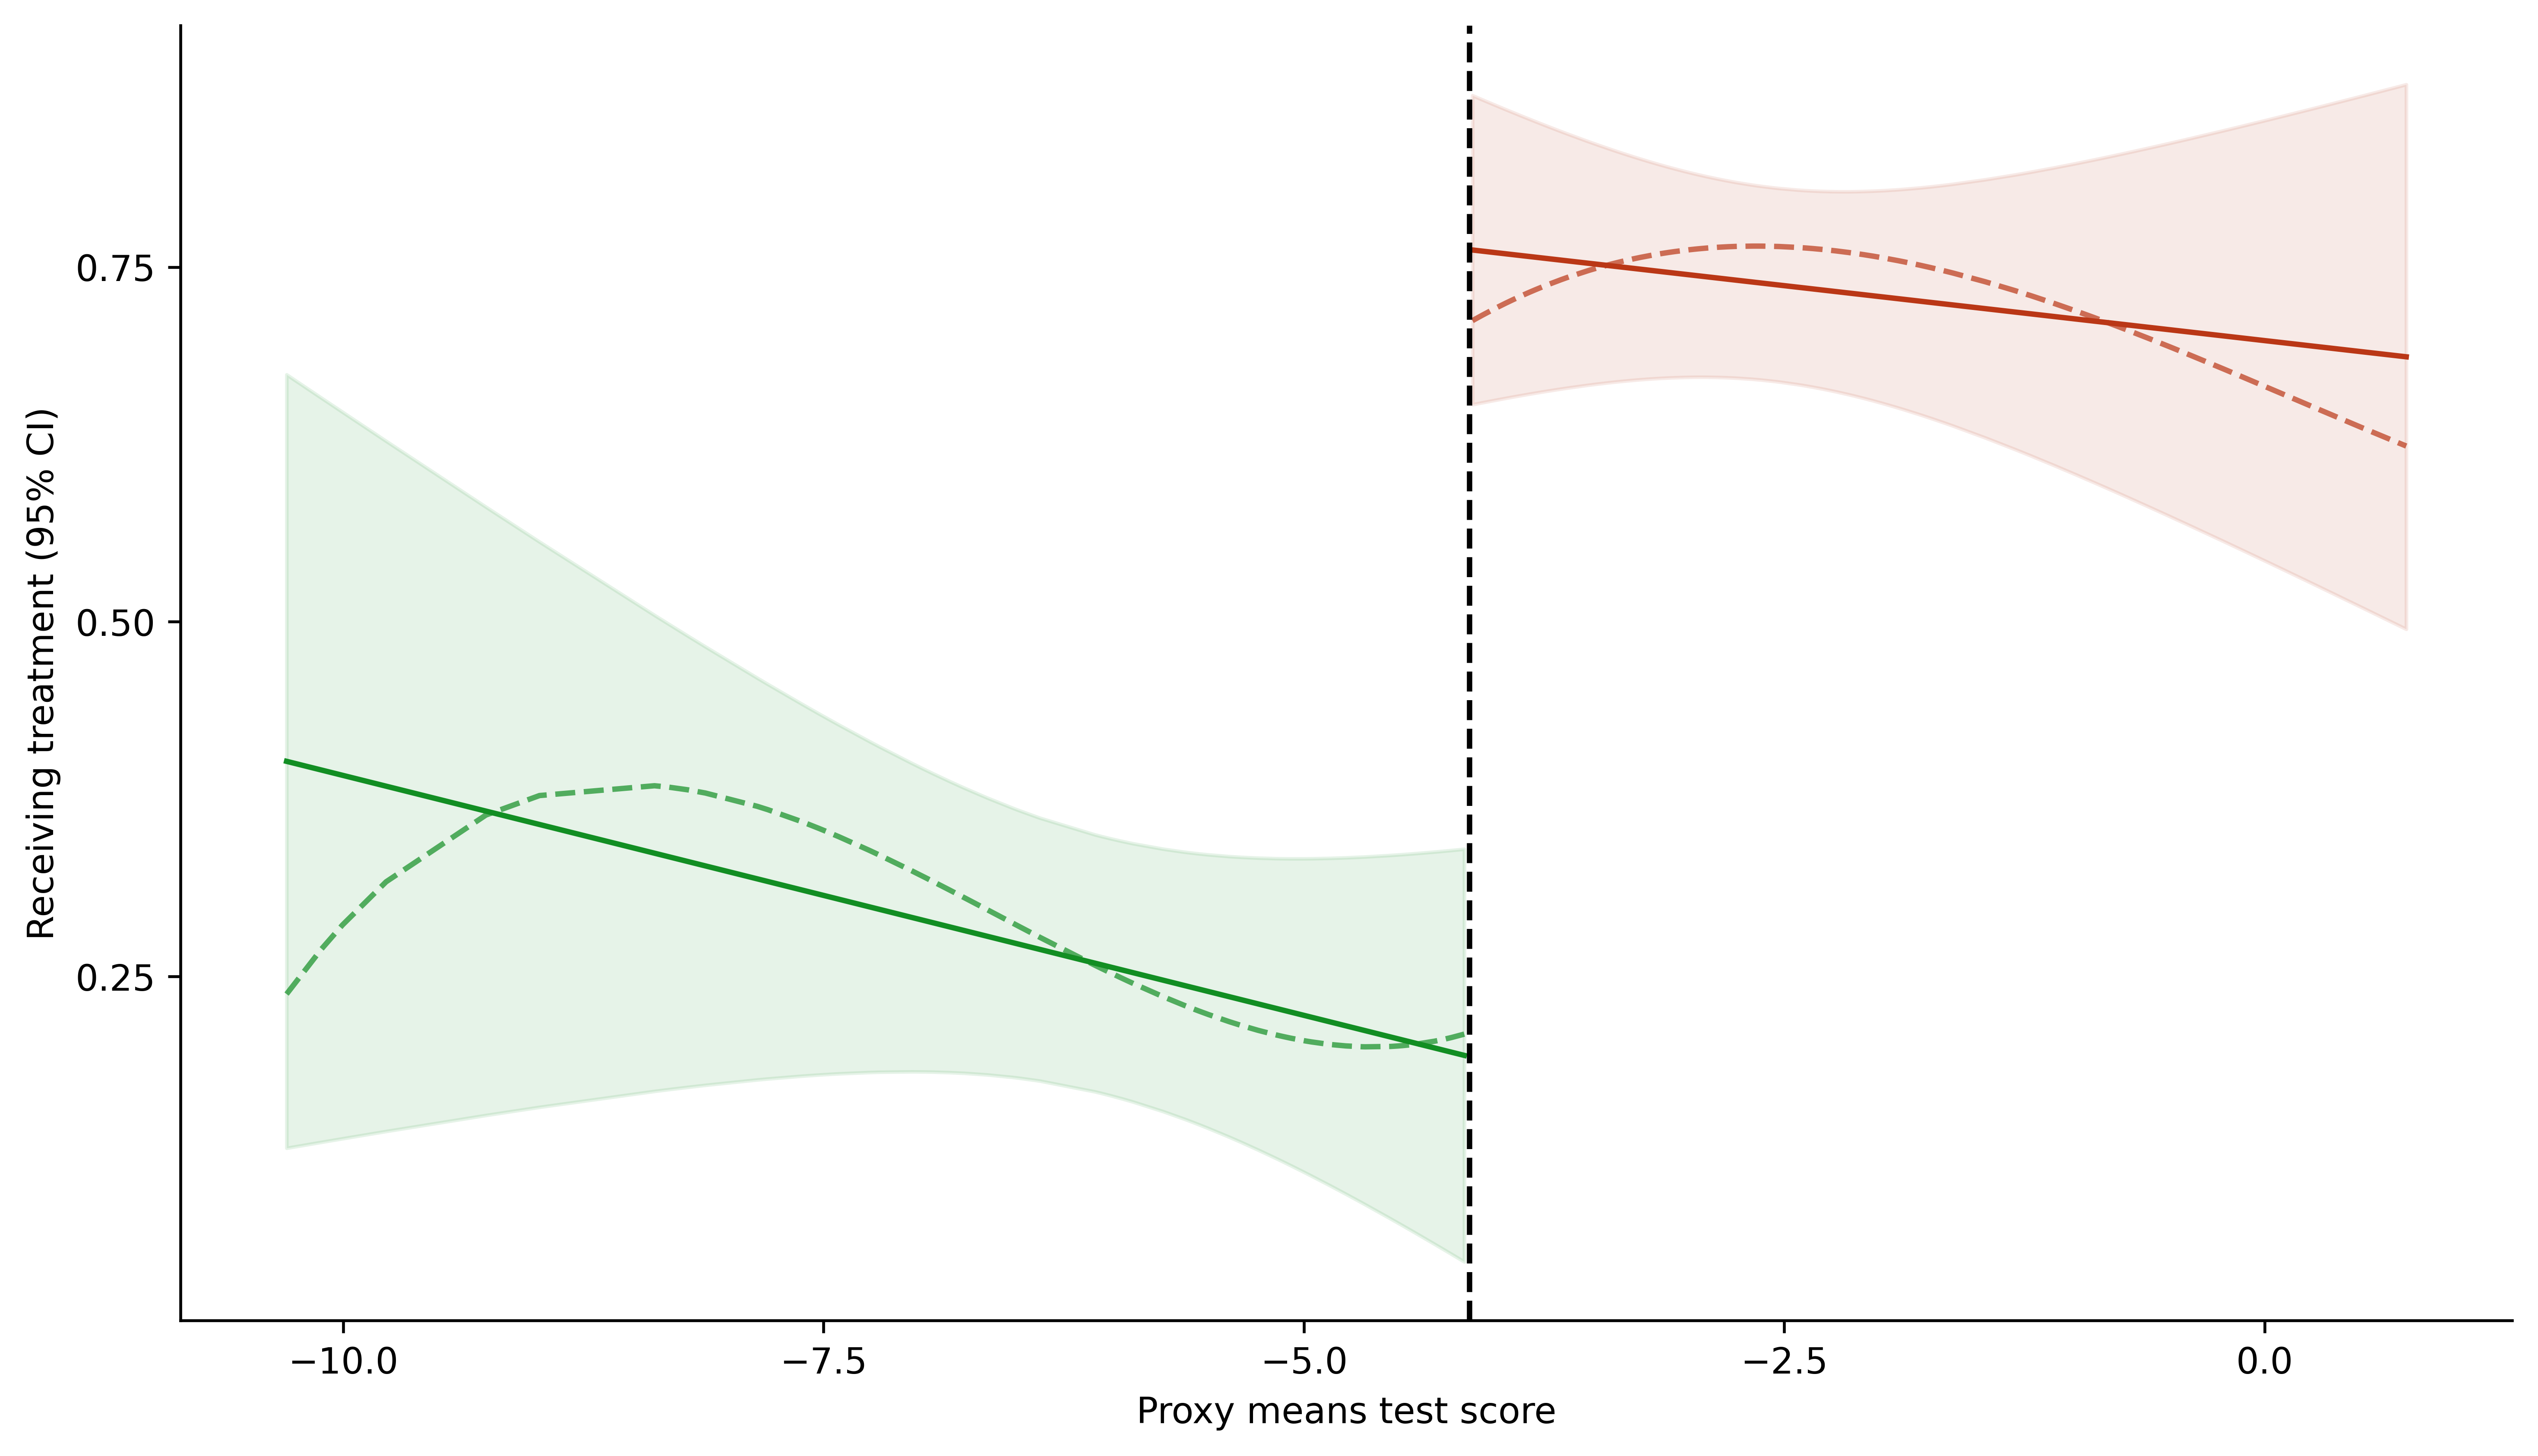

In [22]:
fig = plt.figure(figsize = (9, 5), facecolor = 'white', dpi = dpi_f)
ax = fig.add_axes([.1, 1, 1, 1])

colors = ["#ba3716", "#128e23"]

ax.plot('pmt_score', 'yhat', data = data2_tr, color = colors[0])
ax.plot('pmt_score', 'yhat', data = data2_cr, color = colors[1])

ax.plot('pmt_score', 'yhat_3', data = data2_tr, linestyle = "--", alpha = .7, lw = 1.5,  color = colors[0])
ax.plot('pmt_score', 'yhat_3', data = data2_cr, linestyle = "--", alpha = .7, lw = 1.5,  color = colors[1])

ax.fill_between('pmt_score', 'upper', 'lower', data = data2_tr, alpha = .1, color = colors[0])
ax.fill_between('pmt_score', 'upper', 'lower', data = data2_cr, alpha = .1, color = colors[1])

ax.axvline(cutoff, color = "black", lw = 1.5, linestyle = "--")
omit = ['right', 'top']
ax.spines[omit].set_visible(False)
ax.set_xlabel("Proxy means test score")
ax.set_ylabel("Receiving treatment (95% CI)")
ax.set_xticks(np.arange(-10, 1, 2.5))
ax.set_yticks(np.arange(0.25, .76, .25));
plt.show();

##  Figure with Points

In [23]:
data = pd.read_stata("https://github.com/d2cml-ai/python_visual_library/raw/main/data/evaluation.dta")
cutoff = 58
data = data[data.treatment_locality == 1]
data['treatment'] = data.poverty_index <= cutoff
features = ["poverty_index", "health_expenditures", "treatment"]
data = data[features]
data.sort_values("poverty_index", inplace=True)
data_treat = data[data.treatment == True]
data_crtl = data[data.treatment == False]
fmla = "health_expenditures ~ bs(poverty_index, df = 3)"
y, x = patsy.dmatrices(fmla, data_treat, return_type="dataframe")
y1, x1 = patsy.dmatrices(fmla, data_crtl, return_type="dataframe")
data_treat['yhat'] = np.concatenate(lr().fit(x, y).predict(x))
data_crtl['yhat'] = np.concatenate(lr().fit(x1, y1).predict(x1))

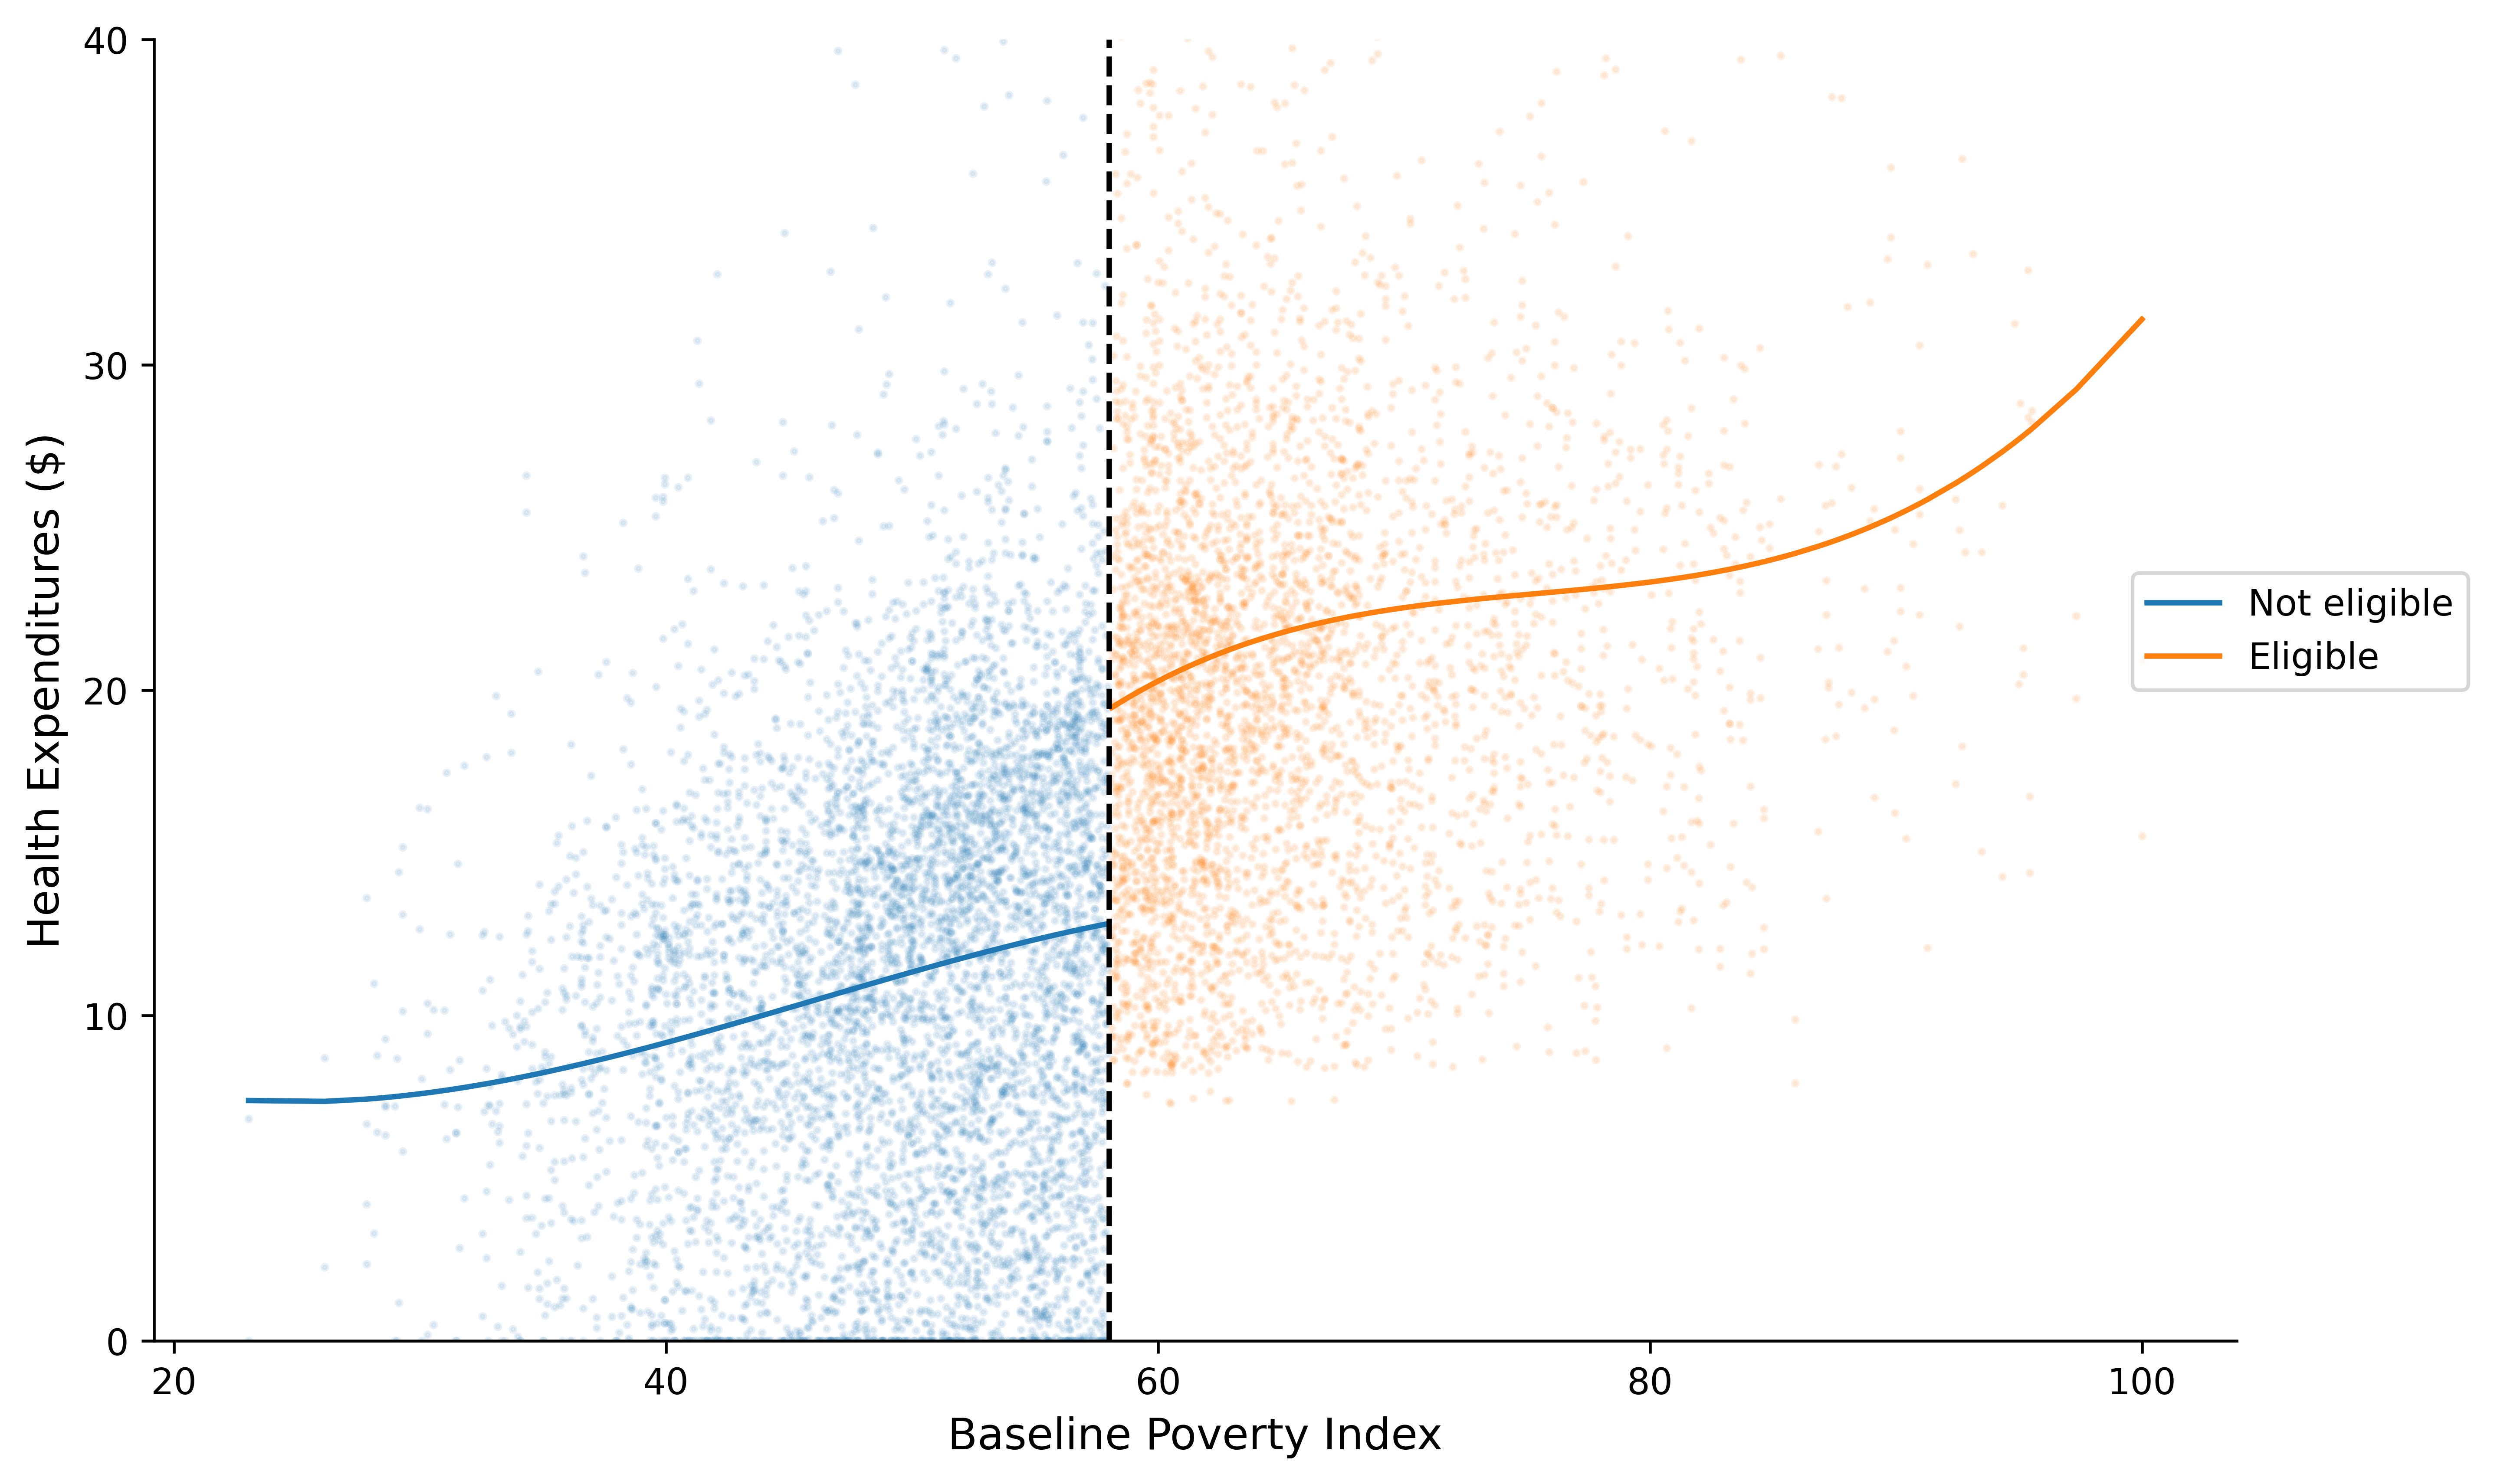

In [24]:
fig = plt.figure(facecolor = 'white', figsize=(8, 5), dpi = dpi_f)
ax = fig.add_axes([.1, 1,1, 1])

ax.plot("poverty_index", "yhat", data = data_treat, label = "Not eligible")
ax.plot("poverty_index", "yhat", data = data_crtl, label = "Eligible")

ax.scatter("poverty_index", "health_expenditures", s = 2, data = data_treat, alpha = .1, label = "")
ax.scatter("poverty_index", "health_expenditures", s = 2, data = data_crtl, alpha = .1, label = "")

omit = ['right', 'top']
ax.spines[omit].set_visible(False)
ax.set_ylim(0, 40)
ax.legend(loc = (.95, .5))
ax.axvline(cutoff, color = "black", linestyle = "--")
ax.set_xlabel("Baseline Poverty Index", size = 12)
ax.set_ylabel("Health Expenditures ($)", size = 12)
ax.set_yticks(np.arange(0, 41, 10))
ax.set_xticks(np.arange(20, 101, 20));
plt.show();